# Recency, Frequency and Monetary Analysis on H&M Data

## 1 Import libraries

In [1]:
import datetime as dt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## 2 Data pre-processing for RFM
- Check variables
- Derive Recency, Frequency and Monetary variables

### 2.1 Read in CSV and Conduct Basic Analysis

In [3]:
# Read in CSV
df = pd.read_csv('data/transactions_train.csv')
print('Dataframe shape:',df.shape)
print('Columns:',list(df.columns))
df.head()

Dataframe shape: (31788324, 5)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id']


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


#### Check for null values

In [4]:
# Basic data check: Check for null values
for col in df.columns:
    print("Number of Null Values in", col, " : ", len(df[df[col].isna()]), "/", len(df))

Number of Null Values in t_dat  :  0 / 31788324
Number of Null Values in customer_id  :  0 / 31788324
Number of Null Values in article_id  :  0 / 31788324
Number of Null Values in price  :  0 / 31788324
Number of Null Values in sales_channel_id  :  0 / 31788324


#### Check data types

In [5]:
# Basic data check: Check data types
df.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [6]:
# Change data type
df = df.astype({'t_dat':'datetime64[ns]',
                'customer_id':'str',
                'article_id':'str',
                'price':'float',
                'sales_channel_id':'str'})
df.dtypes

t_dat               datetime64[ns]
customer_id                 object
article_id                  object
price                      float64
sales_channel_id            object
dtype: object

In [22]:
# Subset relevant columns and 
# Change order of dataframe to place customer_id at the front
cols = ['customer_id','t_dat','price','article_id','sales_channel_id']
df_new = df[cols]
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004,2
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003,2
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004,2


#### Check for outliers

In [8]:
def hist_boxplot(df, var_col, condition=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    if condition:
        df = df[df[var_col] < condition]
    df.hist(column=[var_col], bins=10, ax=axes[0])
    axes[0].set_title(f'Distribution of {var_col} using Histogram')
    axes[0].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    df.boxplot(column=[var_col], return_type='axes', ax=axes[1])
    axes[1].set_title(f'Distribution of {var_col} using Boxplot')

    plt.show()

In [9]:
df_new.head()

,customer_id,t_dat,price,article_id,sales_channel_id
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.050831,663713001,2
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2018-09-20,0.030492,541518023,2
2,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.015237,505221004,2
3,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687003,2
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,2018-09-20,0.016932,685687004,2


Check `price`

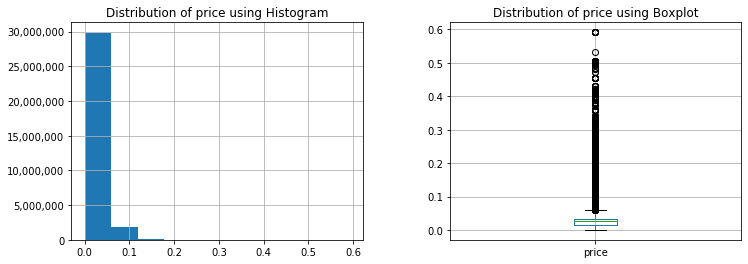

In [10]:
hist_boxplot(df_new, 'price')

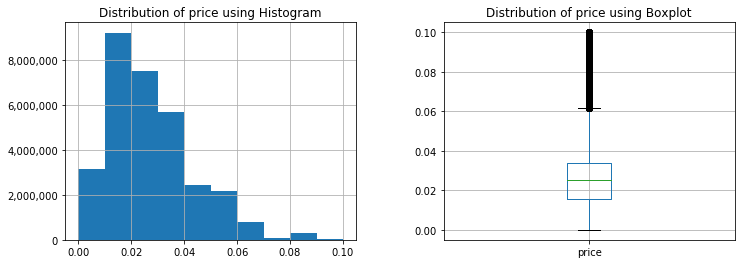

In [11]:
hist_boxplot(df_new, 'price', 0.1)

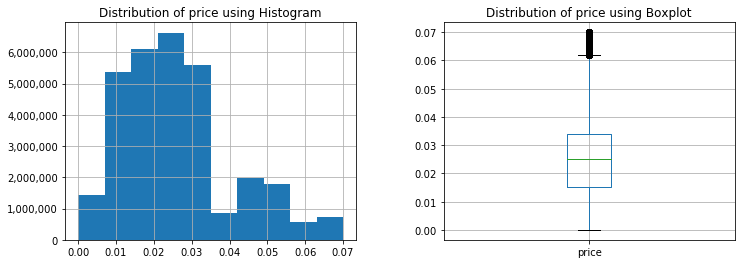

In [12]:
hist_boxplot(df_new, 'price', 0.07) # final distribution upon removal of outliers

Check number of transactions by each customer_id

In [13]:
t_by_customer = df_new.groupby('customer_id', as_index=False).size()
print(len(t_by_customer))
t_by_customer.head()

1362281


,customer_id,size
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,21
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,86
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,18
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,13


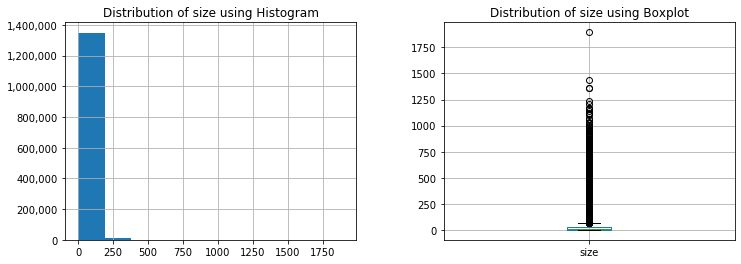

In [14]:
hist_boxplot(t_by_customer, 'size')

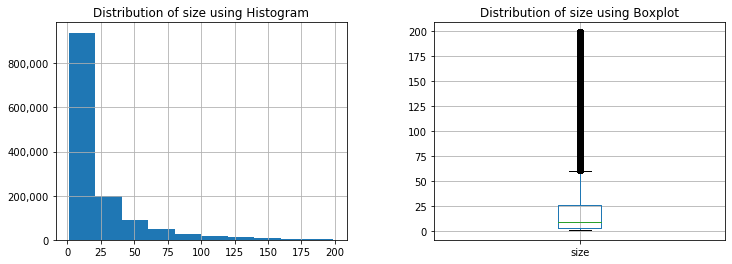

In [15]:
hist_boxplot(t_by_customer, 'size', 200)

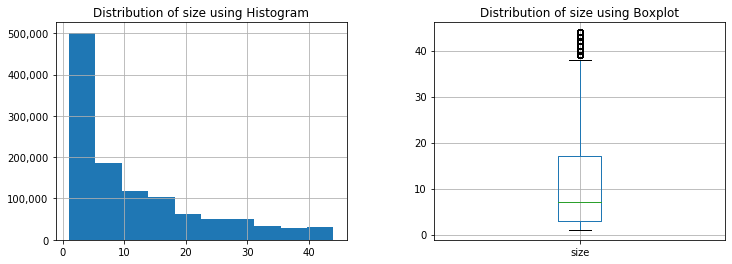

In [16]:
hist_boxplot(t_by_customer, 'size', 45) # final distribution upon removal of outliers

Check articles purchased in transactions

In [17]:
t_by_article = df_new.groupby('article_id', as_index=False).size()
print(len(t_by_article))
t_by_article.head()

104547


,article_id,size
0,108775015,10841
1,108775044,7250
2,108775051,215
3,110065001,1044
4,110065002,539


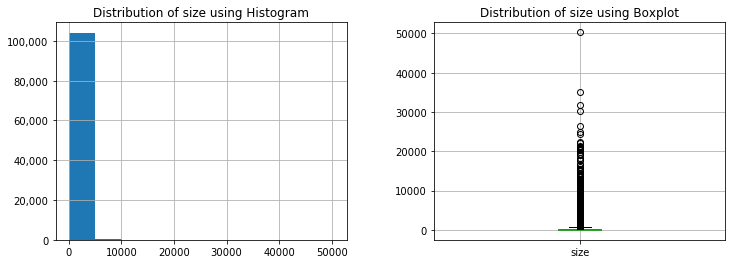

In [18]:
hist_boxplot(t_by_article, 'size')

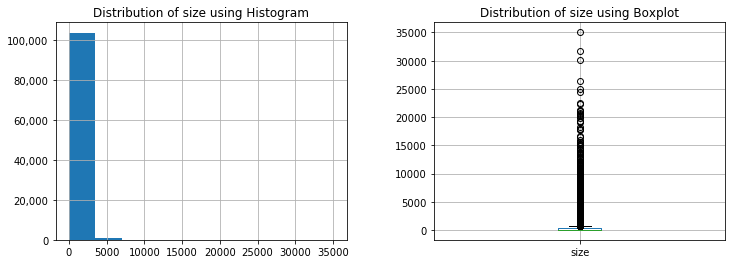

In [19]:
hist_boxplot(t_by_article, 'size', 50000)

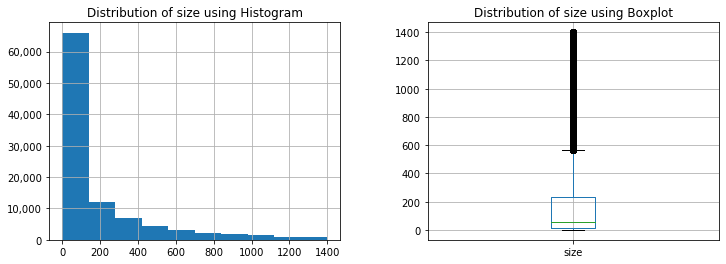

In [20]:
hist_boxplot(t_by_article, 'size', 1400)

In [23]:
# Filter out customer_ids with number of transactions too high or spend too little money
# > Filter out transactions with price <= 0.1
# > Filter out customer_ids with number of transactions <= 50

len1 = len(df_new)
print('Original length of transactions df:', len1)

df_new = df_new[df_new['price'] < 0.07]
len2 = len(df_new)
print('Length of transactions df after removing transactions with price >=0.07:', len2)

t_by_customer = df_new.groupby('customer_id', as_index=False).size()
t_by_customer = t_by_customer[t_by_customer['size'] < 45]
filtered_cust = list(t_by_customer['customer_id'].unique())
df_new = df_new[df_new['customer_id'].isin(filtered_cust)]
len3 = len(df_new)
print('Length of transactions df after removing customers >=50 trans:', len3)

t_by_article = df_new.groupby('article_id', as_index=False).size()
t_by_article = t_by_article[t_by_article['size'] < 1400]
filtered_article = list(t_by_article['article_id'].unique())
df_new = df_new[df_new['article_id'].isin(filtered_article)]
len4 = len(df_new)
print('Length of transactions df after removing customers >=50 trans:', len4)

Original length of transactions df: 31788324
Length of transactions df after removing transactions with price >=0.07: 31028759
Length of transactions df after removing customers >=50 trans: 13001493
Length of transactions df after removing customers >=50 trans: 10249803


In [24]:
print('Proportion of data kept: '+str((len4/len1) * 100)+'%')

Proportion of data kept: 32.24392390111539%


### 2.2 Create dataframe for RFM analysis

#### Check number of unique customers

In [25]:
# Check number of unique customers BEFORE removing outliers
len(df['customer_id'].unique())

1362281

In [26]:
# Check number of unique customers AFTER removing outliers
len(df_new['customer_id'].unique())

1108760

#### Recency

In [27]:
# Subset dataset to get customer_id and t_dat to compute recency
df_recency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_recency) == len(df_new)) # check
# df_recency.head()

True


In [28]:
print(df_recency['t_dat'].max())

2020-09-22 00:00:00


In [29]:
# Get last date of purchase
df_recency = pd.DataFrame(df_recency.groupby('customer_id')['t_dat'].max()).reset_index()
print(len(df_recency) == len(df_new['customer_id'].unique()))
# df_recency.head()

True


In [30]:
# Calculate recency based on 2020-10-01
date = dt.datetime(2020, 10, 1)
df_recency['Recency'] = df_recency.t_dat.apply(lambda x:(date - x).days)
df_recency.head()

,customer_id,t_dat,Recency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2020-09-05,26
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,2020-09-15,16
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2019-06-09,480
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,2020-08-12,50
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,2019-10-02,365


#### Frequency

In [31]:
# Subset dataset to get customer_id and t_dat to compute frequency
df_frequency = df_new.loc[:,['customer_id','t_dat']]
print(len(df_frequency) == len(df_new)) # check
# df_frequency.head()

True


In [32]:
# Calculate frequency based on total number of purchases
df_frequency = pd.DataFrame(df_frequency.groupby('customer_id')['t_dat'].count()).reset_index()
print(len(df_frequency) == len(df_new['customer_id'].unique()))
df_frequency.columns = ['customer_id', 'Frequency']
df_frequency.head()

True


,customer_id,Frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,17
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,15
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,2
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,11
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,1


(array([536534., 182184., 113513.,  97773.,  57256.,  45158.,  41182.,
         21231.,  10817.,   3112.]),
 array([ 1. ,  5.3,  9.6, 13.9, 18.2, 22.5, 26.8, 31.1, 35.4, 39.7, 44. ]),
 <a list of 10 Patch objects>)

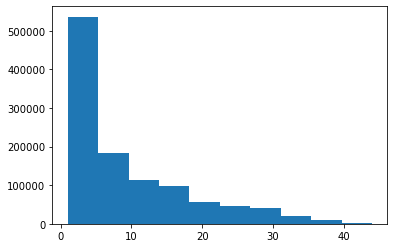

In [33]:
plt.hist(df_frequency['Frequency'])

#### Monetary

In [34]:
# Subset dataset to get customer_id and price to compute monetary
df_monetary = df_new.loc[:,['customer_id','price']]
print(len(df_monetary) == len(df_new)) # check
# df_monetary.head()

True


In [35]:
# Calculate monetary based on average amount spent per transaction
df_monetary = pd.DataFrame(df_monetary.groupby('customer_id')['price'].mean()).reset_index()
print(len(df_monetary) == len(df_new['customer_id'].unique()))
df_monetary.columns = ['customer_id', 'Monetary']
df_monetary.head()

True


,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030104
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.042356
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.037310
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,0.042356


In [36]:
# Multiply by 1000
df_monetary['Monetary'] = df_monetary['Monetary']*1000
df_monetary.head()

,customer_id,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,30.103689
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,42.355932
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,30.491525
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,37.309707
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,42.355932


(array([  7768.,  77985., 231397., 333939., 248225., 100077.,  57107.,
         30842.,  11252.,  10168.]),
 array([ 0.69491525,  7.57288136, 14.45084746, 21.32881356, 28.20677966,
        35.08474576, 41.96271186, 48.84067797, 55.71864407, 62.59661017,
        69.47457627]),
 <a list of 10 Patch objects>)

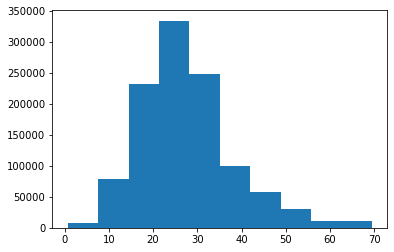

In [37]:
plt.hist(df_monetary['Monetary'])

## 3 RFM analysis
https://github.com/klaudia-nazarko/rfm-analysis-python/blob/master/rfm_analysis_python.ipynb

### 3.1 Combine RFM into a single dataframe
- `Recency`: Number of days from latest transaction date to 2020-10-1 (because the latest t_dat in dataset is 2020-9-22 so chose 2020-10-1 as a reasonable benchmark)
- `Frequency`: Number of transactions per customer_id
- `Money`: Average spending per transaction

In [38]:
df_rfm = pd.merge(df_recency, df_frequency, on='customer_id')
df_rfm = pd.merge(df_rfm, df_monetary, on='customer_id')
df_rfm = df_rfm.drop(['t_dat'], axis=1)
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1108760, 4)


,customer_id,Recency,Frequency,Monetary
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,365,1,42.355932


#### Normalize by scaling

In [39]:
# MinMaxScaler - couln't really differentiate between segments
# from sklearn import preprocessing

# rfm = df_rfm.drop(['customer_id'], axis=1)
# x = rfm.values # returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# rfm = pd.DataFrame(x_scaled, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
# rfm.head()

In [40]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

rfm = df_rfm.drop(['customer_id'], axis=1)

scaler = StandardScaler()
scaler.fit(rfm)
customers_normalized = scaler.transform(rfm)

rfm = pd.DataFrame(customers_normalized, columns=['Recency_norm','Frequency_norm','Monetary_norm'])
rfm.head()

# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[-0. -0. -0.]
[1. 1. 1.]


In [41]:
rfm.insert(0, "customer_id", df_rfm.customer_id)
rfm.head()

,customer_id,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,-1.123901,0.868206,0.241445
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-1.168470,0.644315,1.393180
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.899531,-0.810976,0.277902
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-1.016935,0.196533,0.918825
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,0.386988,-0.922921,1.393180


In [42]:
df_rfm['Recency_norm'] = rfm['Recency_norm']
df_rfm['Frequency_norm'] = rfm['Frequency_norm']
df_rfm['Monetary_norm'] = rfm['Monetary_norm']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689,-1.123901,0.868206,0.241445
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932,-1.168470,0.644315,1.393180
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,0.899531,-0.810976,0.277902
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707,-1.016935,0.196533,0.918825
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,365,1,42.355932,0.386988,-0.922921,1.393180


In [43]:
# Check
print(min(df_rfm['Recency_norm']), max(df_rfm['Recency_norm']))
print(min(df_rfm['Frequency_norm']), max(df_rfm['Frequency_norm']))
print(min(df_rfm['Monetary_norm']), max(df_rfm['Monetary_norm']))

-1.1996683271304116 2.0672390570484667
-0.9229212473597292 3.890733056155816
-2.5230389957044412 3.9423869939832787


(array([536534., 182184., 113513.,  97773.,  57256.,  45158.,  41182.,
         21231.,  10817.,   3112.]),
 array([-0.92292125, -0.44155582,  0.03980961,  0.52117504,  1.00254047,
         1.4839059 ,  1.96527133,  2.44663677,  2.9280022 ,  3.40936763,
         3.89073306]),
 <a list of 10 Patch objects>)

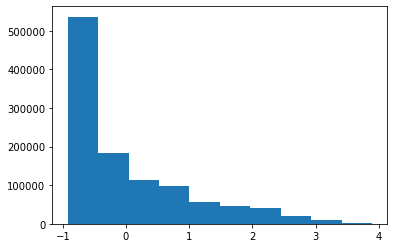

In [44]:
plt.hist(df_rfm['Frequency_norm'])

(array([  7768.,  77985., 231397., 333939., 248225., 100077.,  57107.,
         30842.,  11252.,  10168.]),
 array([-2.523039  , -1.8764964 , -1.2299538 , -0.5834112 ,  0.0631314 ,
         0.709674  ,  1.3562166 ,  2.0027592 ,  2.6493018 ,  3.2958444 ,
         3.94238699]),
 <a list of 10 Patch objects>)

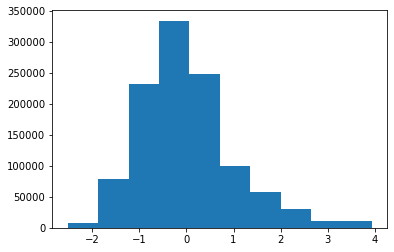

In [45]:
plt.hist(df_rfm['Monetary_norm'])

### 3.2 Conduct RFM Analysis by grouping customers into segments
- Recency: (shortened interval because shopping for clothes is a necessity)
    - Active: Purchase within past 6 months
    - Warm: Purchase within past 1 year
    - Cold/Lost: Purchase beyond 1 year
- Frequency:
    - Frequent: Top 20%
    - Less frequent: Bottom 80%
- Monetary:
    - Valuable: Top 20%
    - Less valuable: Bottom 80%

In [46]:
# assign recency label
bins = [0,6*30,12*30,1000]

r_labels = ['Active','Warm','Cold/Lost']
df_rfm['r_label'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_labels, right=False)

# r_scores = [4,3,2,1]
# df_rfm['r_score'] = pd.cut(df_rfm['Recency'], bins=bins, labels=r_scores, right=False).astype(int)

In [47]:
# assign frequency label
#bins = [0, np.percentile(df_rfm.Frequency_norm,20), 1.1]
bins = [min(df_rfm.Frequency_norm)-0.01, np.percentile(df_rfm.Frequency_norm,20), max(df_rfm.Frequency_norm)+0.01]

f_labels = ['Less frequent','Frequent']
df_rfm['f_label'] = pd.cut(df_rfm['Frequency_norm'], bins=bins, labels=f_labels, right=False)

# f_scores = [1,2,3]
# df_rfm['f_score'] = pd.qcut(df_rfm['Frequency'], q=3, labels=f_scores).astype(int)

In [48]:
# assign monetary label
#bins = [0, np.percentile(df_rfm.Monetary_norm,20), 1.1]
bins = [min(df_rfm.Monetary_norm)-0.01, np.percentile(df_rfm.Monetary_norm,20), max(df_rfm.Monetary_norm)+0.01]

m_labels = ['Less valuable','Valuable']
df_rfm['m_label'] = pd.cut(df_rfm['Monetary_norm'], bins=bins, labels=m_labels, right=False)

# m_scores = [2,1]
# df_rfm['m_score'] = pd.cut(df_rfm['Monetary'], bins=bins, labels=m_scores, right=False).astype(int)

In [49]:
# Add a column to sum rfm scores
# df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']
df_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689,-1.123901,0.868206,0.241445,Active,Frequent,Valuable
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932,-1.168470,0.644315,1.393180,Active,Frequent,Valuable
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,0.899531,-0.810976,0.277902,Cold/Lost,Frequent,Valuable
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707,-1.016935,0.196533,0.918825,Active,Frequent,Valuable
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,365,1,42.355932,0.386988,-0.922921,1.393180,Cold/Lost,Less frequent,Valuable


#### RFM Customer Segments
- Champions: High on all RFM factors
- Loyal: May not have high Monetary, but high on Recency and Frequency (i.e. visits stores often, maybe to check out new goods)
- Provide attention: Customers who have at least 1 high but not more than 2 high out of the RFM attributes (these customers are either willing to pay, willing to visit the store or show interest with their recent visit > therefore, we could try to capture these customers to earn profits from them)
- Unprofitable: No point in investing in these customers as they demonstrate low interest via their visits to the store or amount of purchase made

In [50]:
def assign_label(df, r_label, f_label, m_label, label, colname='rfm_label'):
    df.loc[(df['r_label']==r_label) & (df['f_label']==f_label)
              & (df['m_label']==m_label), colname] = label
    return df

# def assign_label(df, r_rule, f_rule, m_rule, label, colname='rfm_label'):
#     df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
#             & (df['f_score'].between(f_rule[0], f_rule[1]))
#             & (df['m_score'].between(m_rule[0], m_rule[1])), colname] = label
#     return df

In [51]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Valuable', 'Champions')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Active', 'Frequent', 'Less valuable', 'Loyal')
df_rfm = assign_label(df_rfm, 'Active', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Frequent', 'Less valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Warm', 'Less frequent', 'Less valuable', 'Provide attention')

df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Valuable', 'Provide attention')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Frequent', 'Less valuable', 'Unprofitable')
df_rfm = assign_label(df_rfm, 'Cold/Lost', 'Less frequent', 'Less valuable', 'Unprofitable')

In [52]:
print('Dataframe shape:',df_rfm.shape)
df_rfm.head()

Dataframe shape: (1108760, 11)


,customer_id,Recency,Frequency,Monetary,Recency_norm,Frequency_norm,Monetary_norm,r_label,f_label,m_label,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,26,17,30.103689,-1.123901,0.868206,0.241445,Active,Frequent,Valuable,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,16,15,42.355932,-1.168470,0.644315,1.393180,Active,Frequent,Valuable,Champions
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,480,2,30.491525,0.899531,-0.810976,0.277902,Cold/Lost,Frequent,Valuable,Provide attention
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,50,11,37.309707,-1.016935,0.196533,0.918825,Active,Frequent,Valuable,Champions
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,365,1,42.355932,0.386988,-0.922921,1.393180,Cold/Lost,Less frequent,Valuable,Unprofitable


In [53]:
df_rfm['rfm_label'].unique()

array(['Champions', 'Provide attention', 'Unprofitable', 'Loyal'],
      dtype=object)

#### Export clusters

In [54]:
df_clusters = df_rfm.loc[:,['customer_id','rfm_label']]
df_clusters.rename({'rfm_label': 'cluster'}, axis=1, inplace=True)
df_clusters.head()

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,Provide attention
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,Unprofitable


In [55]:
df_clusters.to_csv('clusters_4.csv', index=False)

## 3.3 RFM Segment Analysis

### 3.3.1 General Analysis on RFM Segments

#### Number of customers in each RFM Segment defined

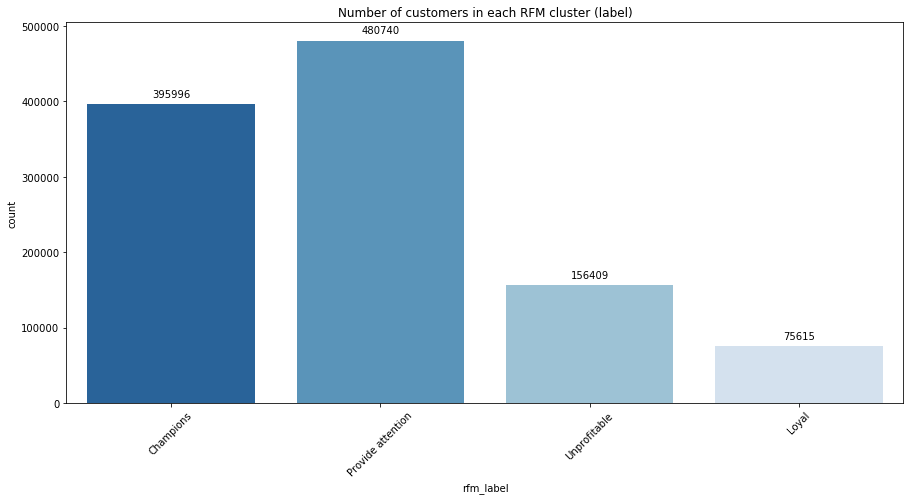

In [56]:
palette = sns.color_palette("Blues_r", n_colors=4)

for rfm_type in ['label']:
    fig, ax = plt.subplots(figsize=(15,7))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=45)
    plt.show()

#### Proportion of customers in each RFM Segment & Proportion of monetary amount by customers in each RFM Segment

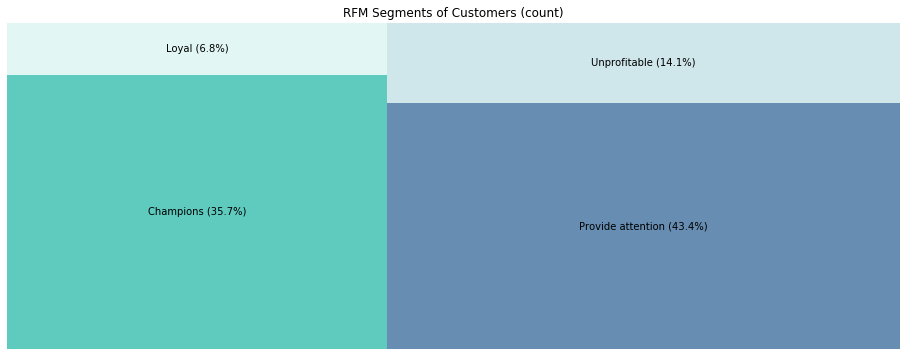

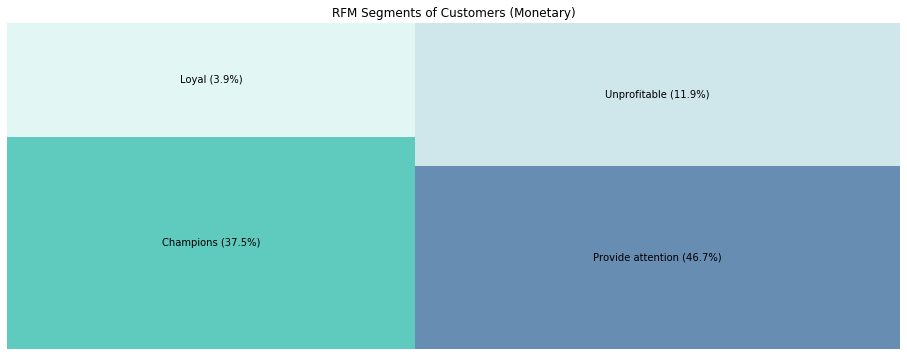

In [57]:
import squarify
agg_dict2 = {
    'customer_id': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'sum',
    'Recency_norm': 'mean',
    'Frequency_norm': 'mean',
    'Monetary_norm': 'mean'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='Recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['Monetary_share'] = df_analysis['Monetary'] / df_analysis['Monetary'].sum()
df_analysis['Monetary'] = df_analysis['Monetary'] / df_analysis['count']

colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'Monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

#### View Recency vs Frequency for each RFM Segment for comparison

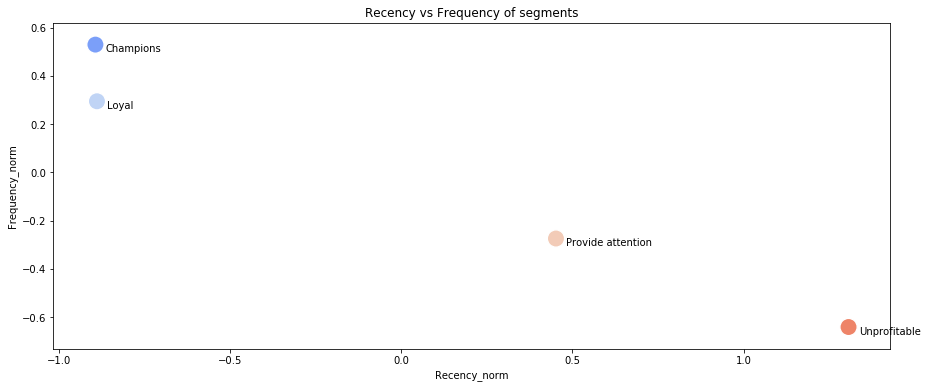

In [58]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Frequency_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Frequency_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Frequency of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Recency vs Monetary of each RFM Segment for comparison

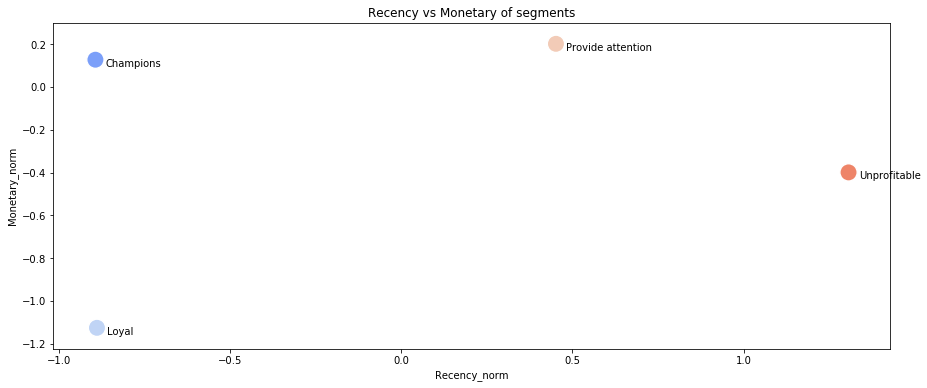

In [59]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Recency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Recency_norm'][i]+0.03, #+0.008,
               df_analysis['Monetary_norm'][i]-0.03, #-0.002,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### View Frequency vs Monetary of each RFM Segment for comparison

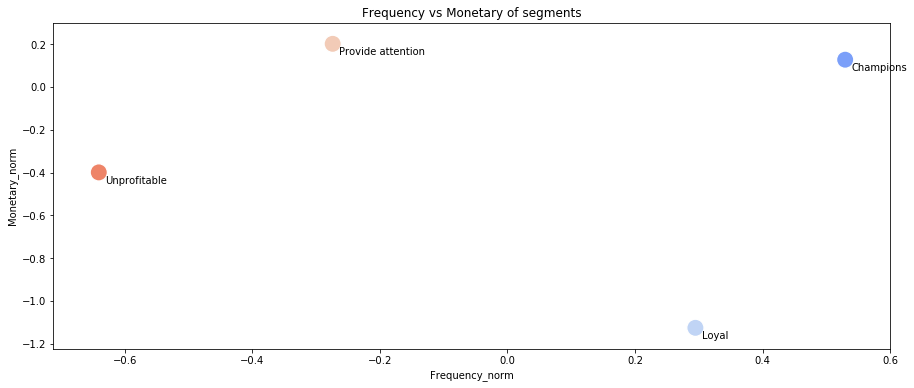

In [60]:
palette = sns.color_palette("coolwarm", 4)

fig, ax = plt.subplots(figsize=(15,6))
plot = sns.scatterplot(x='Frequency_norm', y='Monetary_norm', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['Frequency_norm'][i]+0.01, #+0.0008,
               df_analysis['Monetary_norm'][i]-0.05, #-0.003,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Frequency vs Monetary of segments')
ax.get_legend().remove()
# plt.legend(loc='upper left')
plt.show()

#### Visualize all elements together - Snakeplot

In [61]:
df_snake = df_rfm.loc[:,['customer_id','Recency_norm','Frequency_norm','Monetary_norm','rfm_label']]
df_snake.rename({'Recency_norm':'recency',
                 'Frequency_norm':'frequency',
                 'Monetary_norm':'monetary',
                 'rfm_label': 'cluster'}, axis=1, inplace=True)
df_snake.head()
df_melt = pd.melt(df_snake.reset_index(), 
                  id_vars=['customer_id','cluster'],
                  value_vars=['recency','frequency','monetary'],
                  var_name='Attribute',
                  value_name='Value')
df_melt.head()

,customer_id,cluster,Attribute,Value
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions,recency,-1.123901
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions,recency,-1.168470
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,Provide attention,recency,0.899531
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions,recency,-1.016935
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,Unprofitable,recency,0.386988


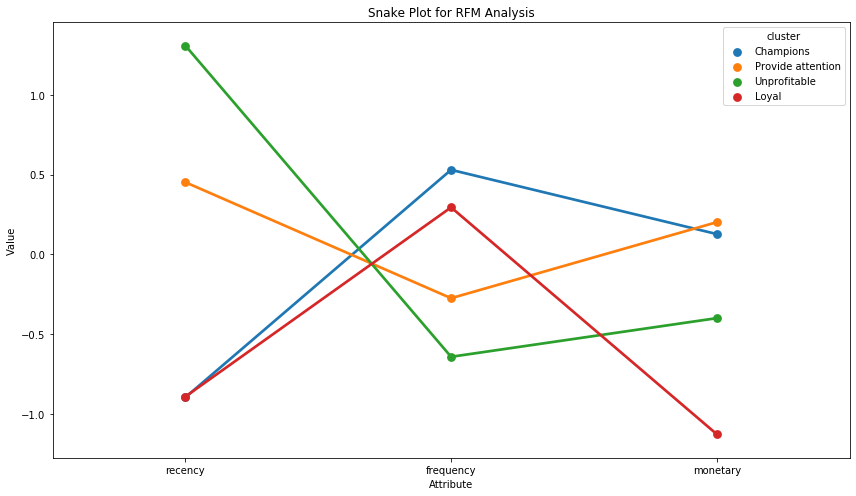

In [62]:
plt.figure(figsize=(12, 7))
plt.title('Snake Plot for RFM Analysis')
plt.xlabel('Attribute')
plt.ylabel('Value')
sns.pointplot(data=df_melt, x='Attribute', y='Value', hue='cluster')

plt.tight_layout()

### 3.3.2 Demographic Analysis of RFM Segments

#### Read in CSV and Conduct Basic Analysis

In [63]:
customers = pd.read_csv('data/customers.csv')
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [64]:
customers = customers.loc[:,['customer_id','Active','club_member_status','fashion_news_frequency','age','postal_code']]
print('Dataframe shape:',customers.shape)
customers.head()

Dataframe shape: (1371980, 6)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [65]:
# Basic data check: Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))

Number of Null Values in customer_id  :  0 / 1371980
Number of Null Values in Active  :  907576 / 1371980
Number of Null Values in club_member_status  :  6062 / 1371980
Number of Null Values in fashion_news_frequency  :  16009 / 1371980
Number of Null Values in age  :  15861 / 1371980
Number of Null Values in postal_code  :  0 / 1371980


In [66]:
# Handle null values
customers['Active'] = customers['Active'].fillna(0)
customers['club_member_status'] = customers['club_member_status'].fillna('NONE')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].fillna('None')
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace(['NONE'],'None')
customers = customers.dropna(subset=['age'])

# Check for null values
for col in customers.columns:
    print("Number of Null Values in", col, " : ", len(customers[customers[col].isna()]), "/", len(customers))
    
customers.dtypes

Number of Null Values in customer_id  :  0 / 1356119
Number of Null Values in Active  :  0 / 1356119
Number of Null Values in club_member_status  :  0 / 1356119
Number of Null Values in fashion_news_frequency  :  0 / 1356119
Number of Null Values in age  :  0 / 1356119
Number of Null Values in postal_code  :  0 / 1356119


customer_id                object
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

In [67]:
# Convert datatypes to suitable datatypes
customers = customers.astype({'customer_id':'str',
                              'Active':'category',
                              'club_member_status':'category',
                              'fashion_news_frequency':'category',
                              'age':'int64',
                              'postal_code':'category'})
customers.dtypes

customer_id                 object
Active                    category
club_member_status        category
fashion_news_frequency    category
age                          int64
postal_code               category
dtype: object

In [68]:
rfm_customers = customers.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')
print('Dataframe shape:',rfm_customers.shape)
rfm_customers.head()

Dataframe shape: (1094679, 10)


,customer_id,Active,club_member_status,fashion_news_frequency,age,postal_code,Recency,Frequency,Monetary,rfm_label
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,ACTIVE,None,49,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,26,17,30.103689,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,ACTIVE,None,24,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,16,15,42.355932,Champions
2,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,ACTIVE,None,54,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,480,2,30.491525,Provide attention
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,ACTIVE,Regularly,52,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,50,11,37.309707,Champions
4,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.0,ACTIVE,None,20,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...,345,3,21.451977,Provide attention


#### Demographic Analysis 1: Descriptive analysis

#### - Demographic Analysis 1.1: Descriptive analysis by Recency, Frequency and Monetary

In [69]:
rfm_customers.groupby('rfm_label')['Recency', 'Frequency', 'Monetary'].describe()

Recency                                               \
                      count        mean         std    min    25%    50%   
rfm_label                                                                  
Champions          393134.0   77.390394   48.034743    9.0   34.0   71.0   
Loyal               75071.0   78.436027   42.850881    9.0   44.0   75.0   
Provide attention  474030.0  378.573656  178.775078    9.0  240.0  336.0   
Unprofitable       152444.0  571.152023  112.740443  360.0  465.0  587.0   

                                Frequency                                 \
                     75%    max     count       mean       std  min  25%   
rfm_label                                                                  
Champions          112.0  179.0  393134.0  13.997449  9.753450  2.0  6.0   
Loyal              105.0  179.0   75071.0  11.886148  9.419321  2.0  4.0   
Provide attention  515.0  742.0  474030.0   6.816809  6.981504  1.0  2.0   
Unprofitable       674.0  742.0  152444.0   3.546870  4.706128  1.0  1.0   

                                     Monetary                        \
                    50%   75%   max     count       mean        std   
rfm_label                                                             
Champions          12.0  21.0  44.0  393134.0  28.887531   7.292126   
Loyal               9.0  17.0  44.0   75071.0  15.562592   2.772970   
Provide attention   4.0   9.0  44.0  474030.0  29.667252  10.693938   
Unprofitable        1.0   4.0  44.0  152444.0  23.228993  14.326807   

                                                                          
                         min        25%        50%        75%        max  
rfm_label                                                                 
Champions          18.970944  23.459322  27.440678  32.751412  68.627119  
Loyal               1.338983  14.032739  16.278719  17.730367  18.970523  
Provide attention   0.762712  22.440678  27.949153  34.446328  69.474576  
Unprofitable        0.694915  13.754237  17.114733  30.491525  69.474576

#### - Demographic Analysis 1.2: Descriptive analysis by customers demographics

In [70]:
rfm_customers.groupby('rfm_label')['Active','club_member_status','fashion_news_frequency','age','postal_code'].describe()

age                                                \
                      count       mean        std   min   25%   50%   75%   
rfm_label                                                                   
Champions          393134.0  35.638815  14.397528  16.0  23.0  30.0  49.0   
Loyal               75071.0  32.386248  13.438974  16.0  21.0  27.0  42.0   
Provide attention  474030.0  37.529433  14.601658  16.0  25.0  34.0  50.0   
Unprofitable       152444.0  37.601782  14.525277  16.0  25.0  35.0  49.0   

                         
                    max  
rfm_label                
Champions          99.0  
Loyal              99.0  
Provide attention  99.0  
Unprofitable       99.0

#### Demographic Analysis 2: Graphic analysis for the different RFM segments (Bottom 2 analyses are the same just displayed in different sequences)

In [71]:
def countplot(df, var_col, xticklabels, rotate=False):
    plt.figure(figsize=(12,5))
    ax = sns.countplot(x=var_col, data=df)
    ax.set(xlabel=var_col, ylabel='Count')
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Distribution of {var_col}')
    plt.show()

#### - Demographic Analysis 2.1: View graphs by RFM Segments (Compare within RFM Segments)

In [72]:
# labels = list(rfm_customers['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_customers[rfm_customers['rfm_label']==label]
#     for col in ['Active','club_member_status','fashion_news_frequency','age']:
#         print('Plotting countplot...')
#         print('RFM Segment:',label)
#         print('Variable:',col)
#         if col=='age':
#             sorted_x = list(subset_df[col].unique())
#             sorted_x.sort()
#             countplot(subset_df, col, sorted_x, rotate=True)
#         else:
#             countplot(subset_df, col, list(subset_df[col].unique()))

#### - Demographic Analysis 2.2: View graphs by Variables (Compare across RFM Segments)

Demographic Analysis 2.2.1: Using bar charts

----- Variable: Active -----
Plotting countplot...
Variable: Active
RFM Segment: Champions


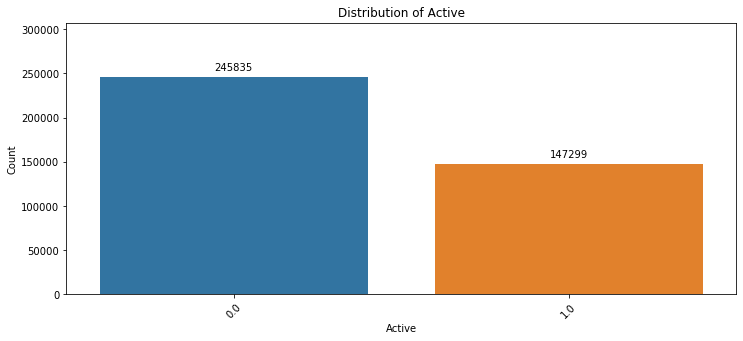

Plotting countplot...
Variable: Active
RFM Segment: Provide attention


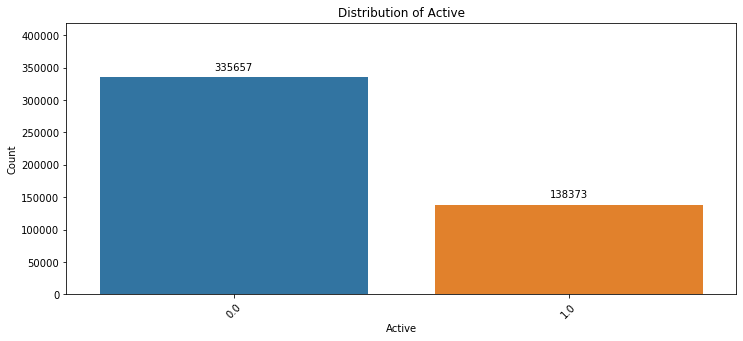

Plotting countplot...
Variable: Active
RFM Segment: Unprofitable


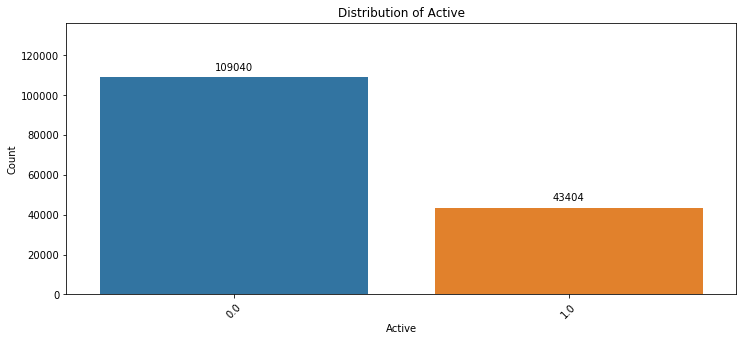

Plotting countplot...
Variable: Active
RFM Segment: Loyal


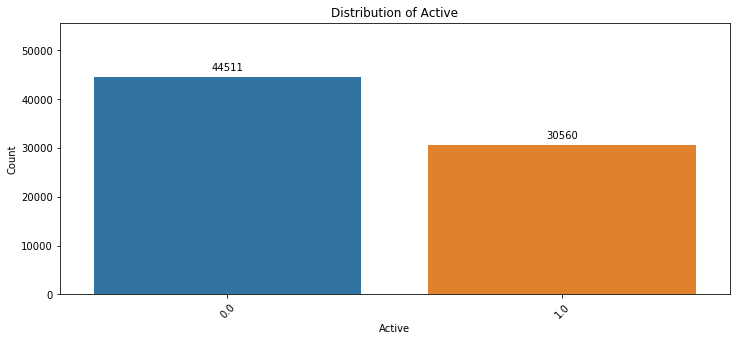

----- Variable: club_member_status -----
Plotting countplot...
Variable: club_member_status
RFM Segment: Champions


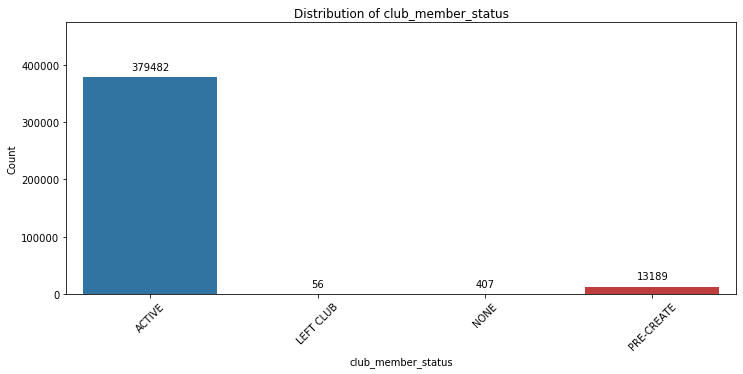

Plotting countplot...
Variable: club_member_status
RFM Segment: Provide attention


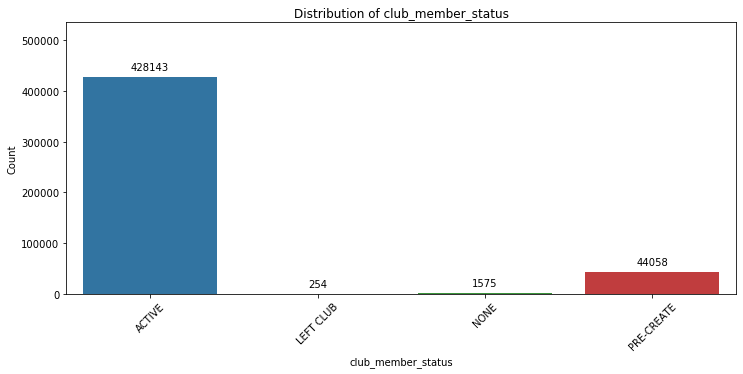

Plotting countplot...
Variable: club_member_status
RFM Segment: Unprofitable


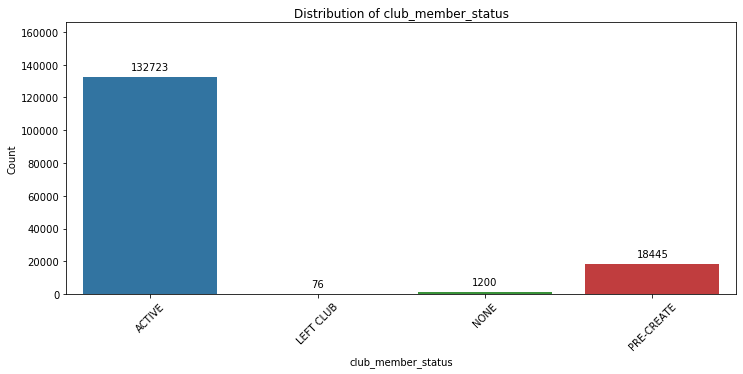

Plotting countplot...
Variable: club_member_status
RFM Segment: Loyal


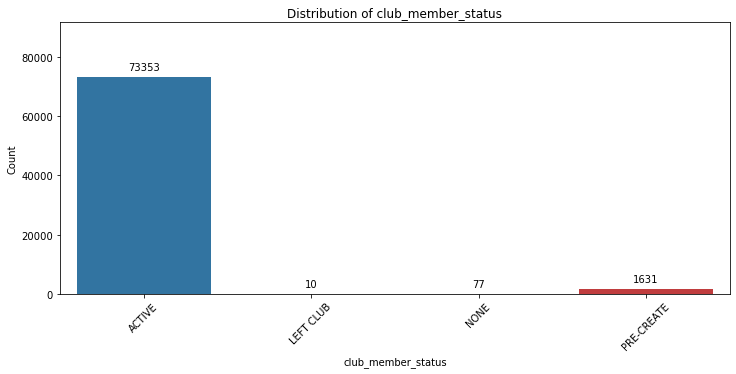

----- Variable: fashion_news_frequency -----
Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Champions


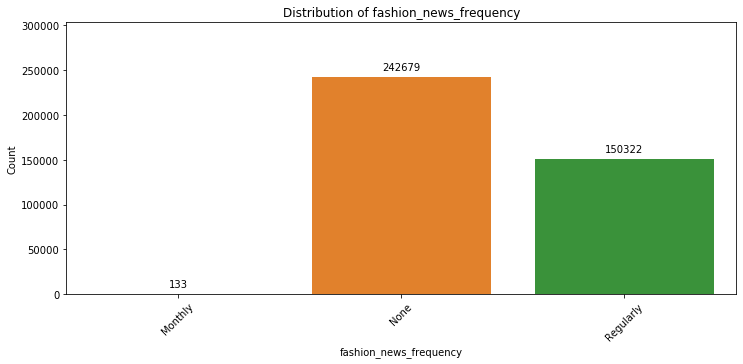

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Provide attention


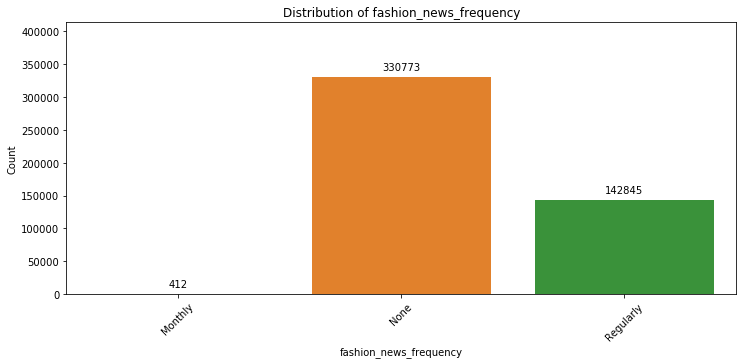

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Unprofitable


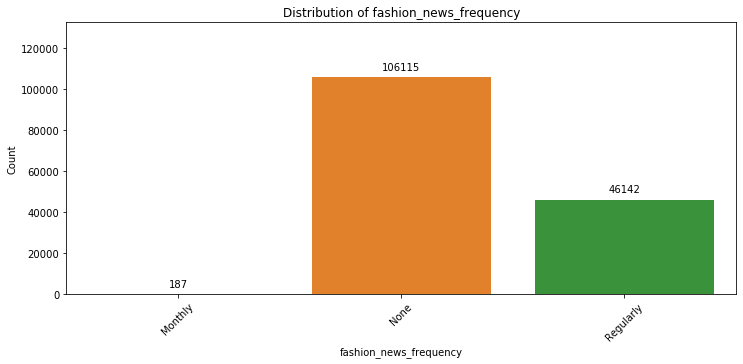

Plotting countplot...
Variable: fashion_news_frequency
RFM Segment: Loyal


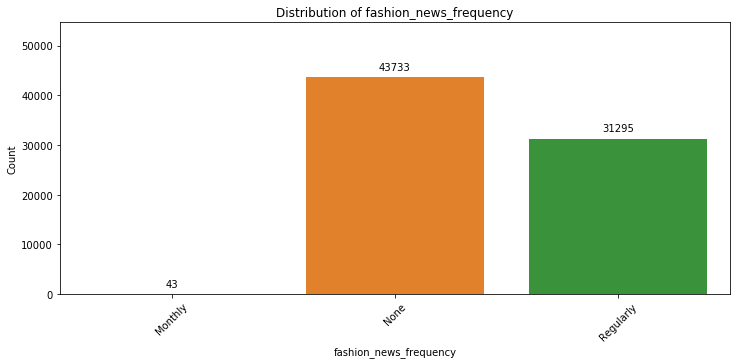

----- Variable: age -----
Plotting countplot...
Variable: age
RFM Segment: Champions


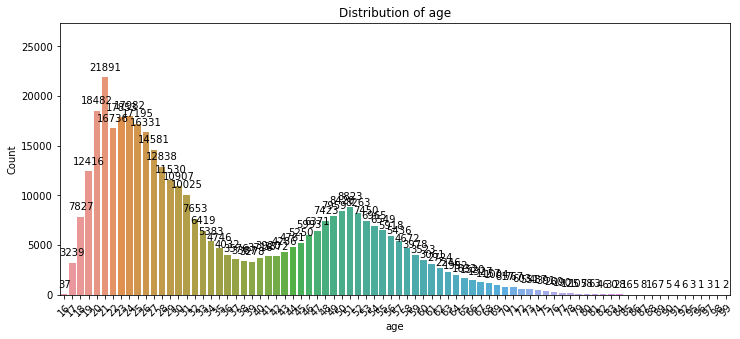

Plotting countplot...
Variable: age
RFM Segment: Provide attention


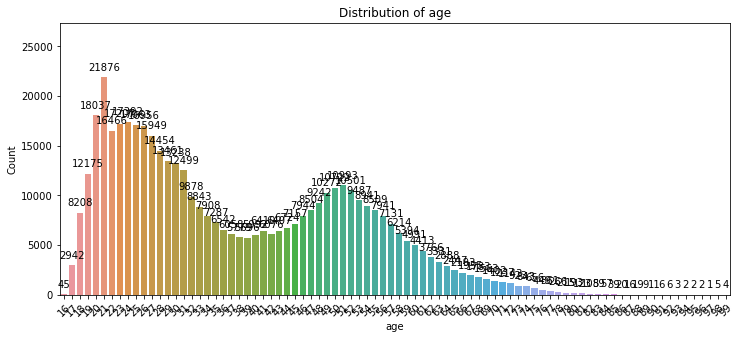

Plotting countplot...
Variable: age
RFM Segment: Unprofitable


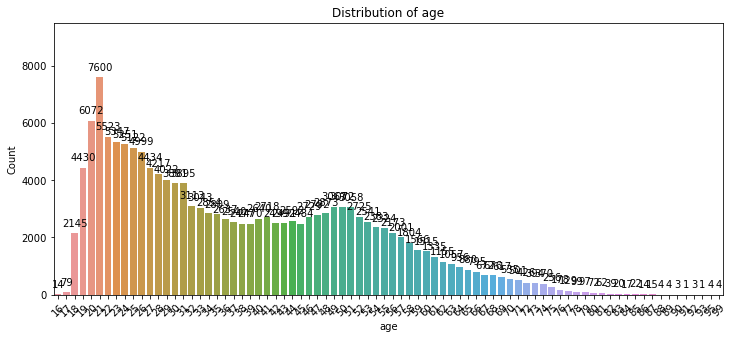

Plotting countplot...
Variable: age
RFM Segment: Loyal


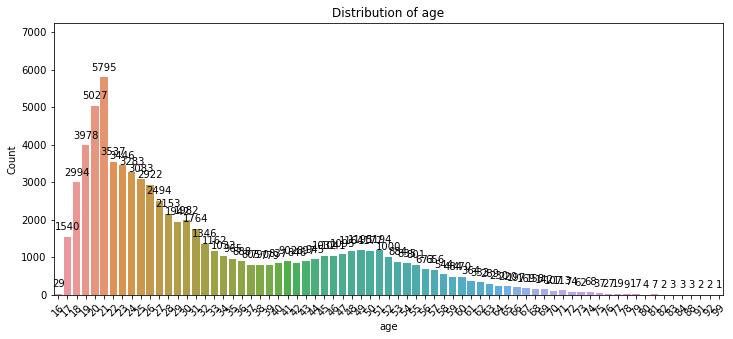

In [73]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency','age']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        print('Plotting countplot...')
        print('Variable:',col)
        print('RFM Segment:',label)
        sorted_x = list(subset_df[col].unique())
        sorted_x.sort()
        countplot(subset_df, col, sorted_x, rotate=True)

Demographic Analysis 2.2.2: Using pie charts (to better see the proportion) *excluded age variable here

----- Variable: Active -----


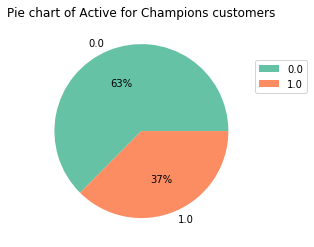

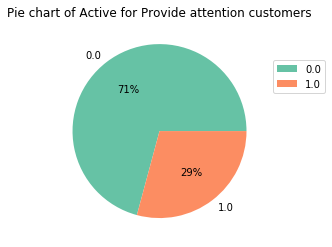

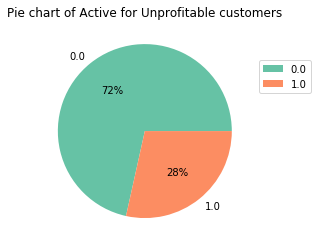

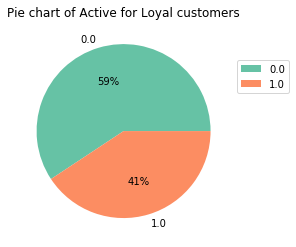

----- Variable: club_member_status -----


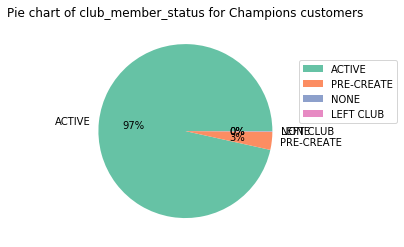

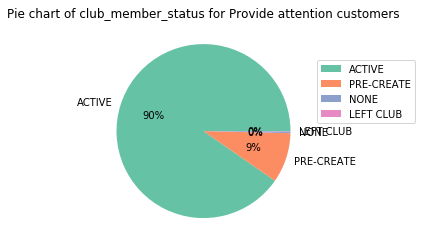

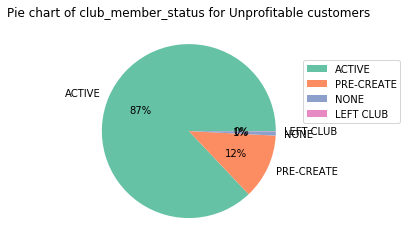

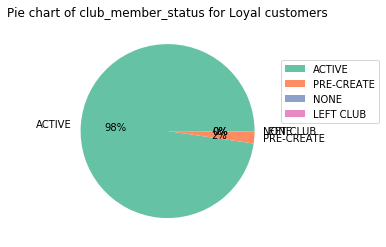

----- Variable: fashion_news_frequency -----


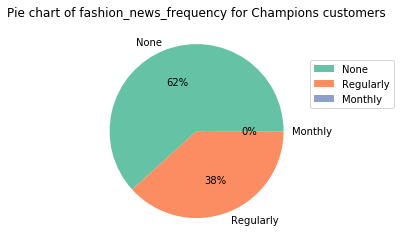

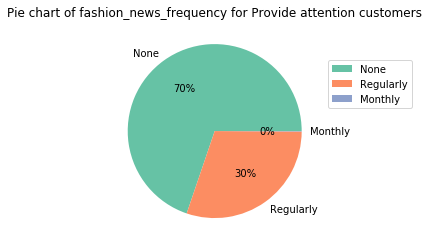

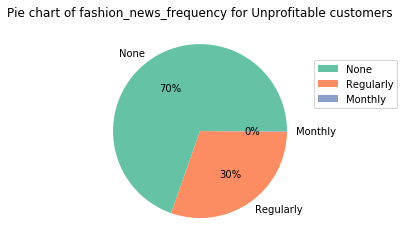

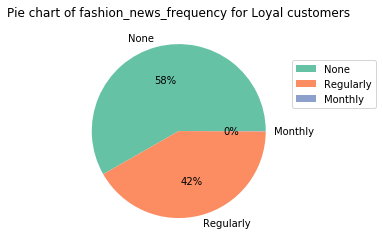

In [74]:
labels = list(rfm_customers['rfm_label'].unique())
for col in ['Active','club_member_status','fashion_news_frequency']:
    print('----- Variable:',col,'-----')
    for label in labels:
        subset_df = rfm_customers[rfm_customers['rfm_label']==label]
        colors = sns.color_palette('Set2')
        plt.pie(subset_df[col].value_counts(), labels=list(subset_df[col].unique()), colors=colors, autopct='%.0f%%')
        plt.title(f'Pie chart of {col} for {label} customers' )
        plt.legend(subset_df[col].value_counts().index, bbox_to_anchor = (1, 0.85))
        plt.show()

### 3.3.3 Comparing Demographics Across Variables

In [75]:
# Find number of unique values in each column
for col in customers.columns[1:]:
    print('Number of unique values in ' + col + ': ' + str(len(customers[col].unique())) + ' / ' + str(len(customers)))

Number of unique values in Active: 2 / 1356119
Number of unique values in club_member_status: 4 / 1356119
Number of unique values in fashion_news_frequency: 3 / 1356119
Number of unique values in age: 84 / 1356119
Number of unique values in postal_code: 351826 / 1356119


#### Age vs Columns

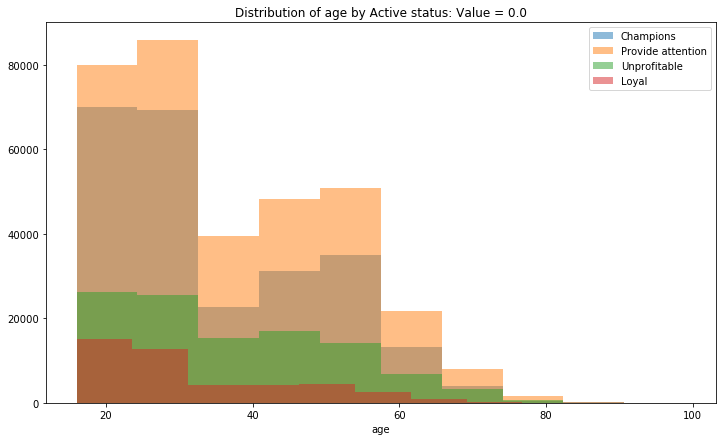

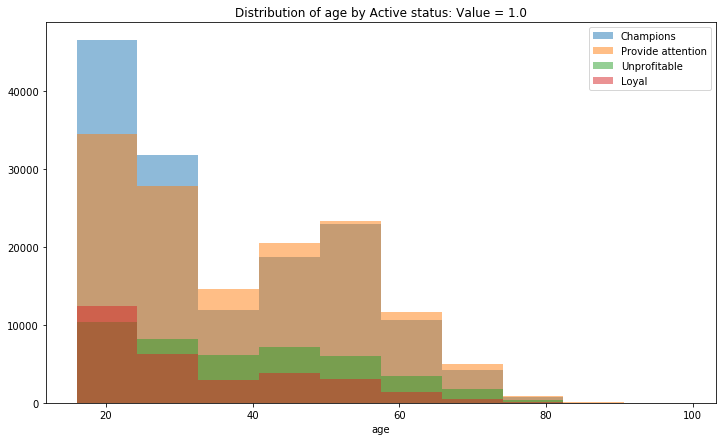

In [76]:
# For Active column
common_col = 'age'
col = 'Active'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

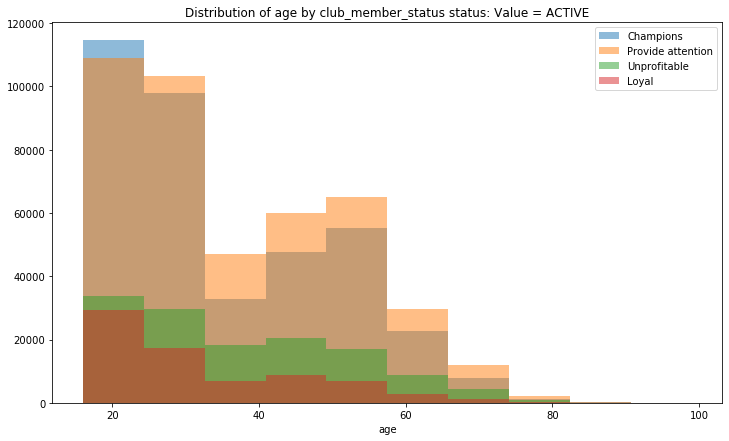

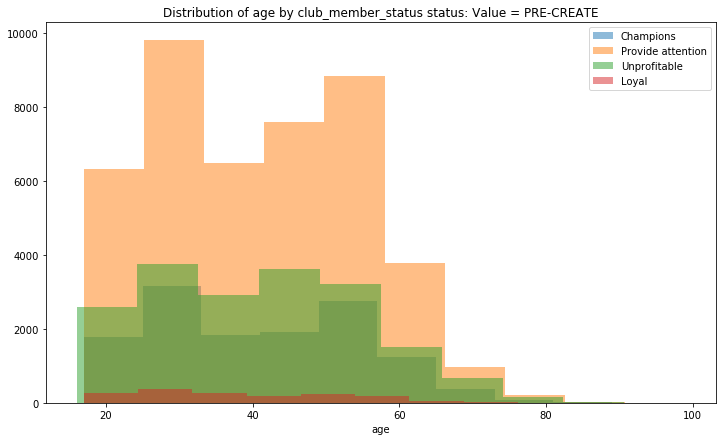

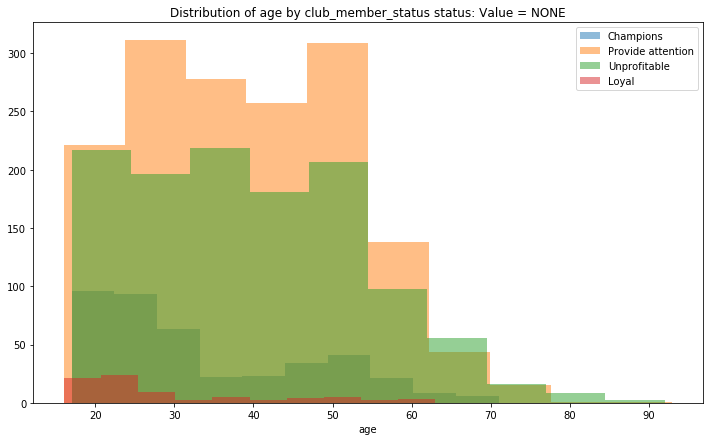

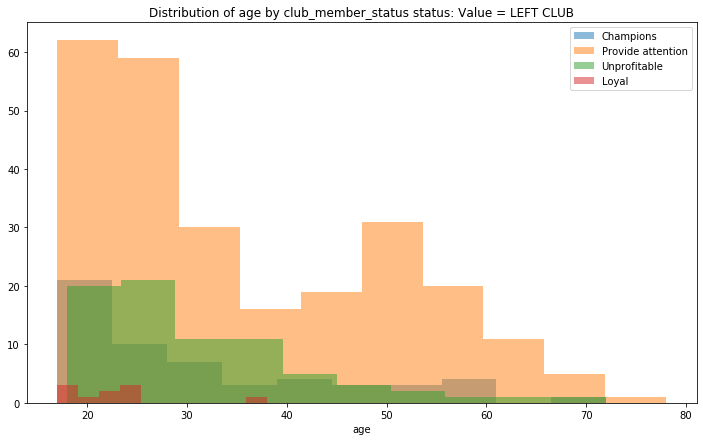

In [77]:
# For club_member_status column
common_col = 'age'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

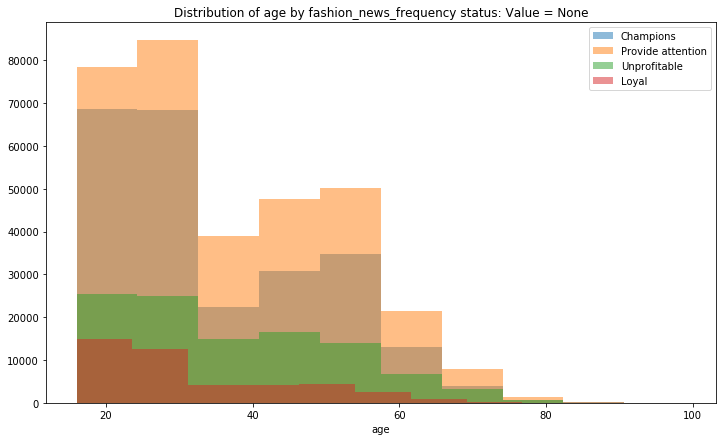

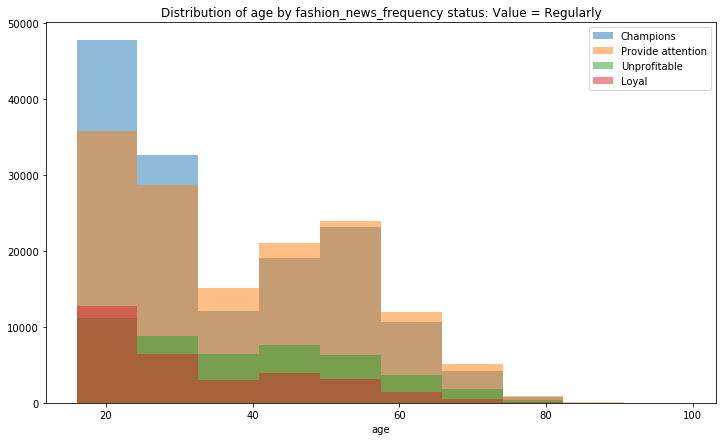

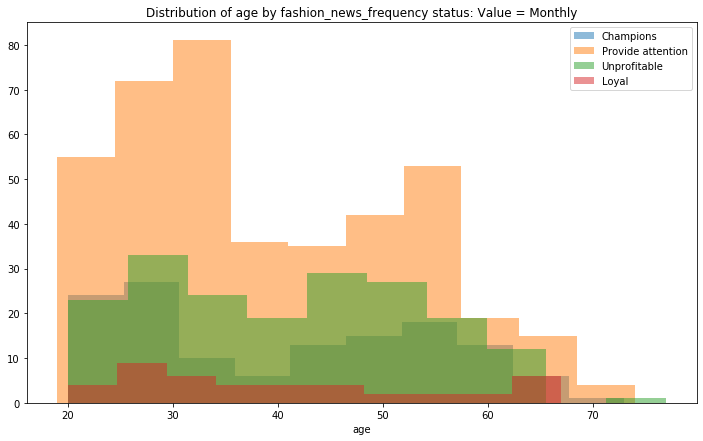

In [78]:
# For fashion_news_frequency column
common_col = 'age'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### Active vs Columns

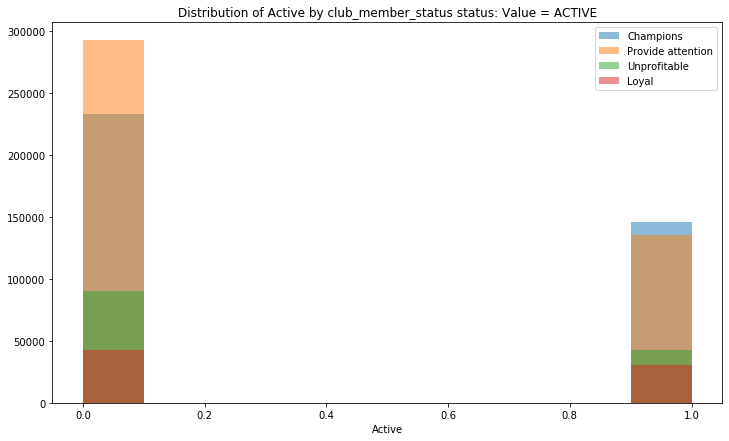

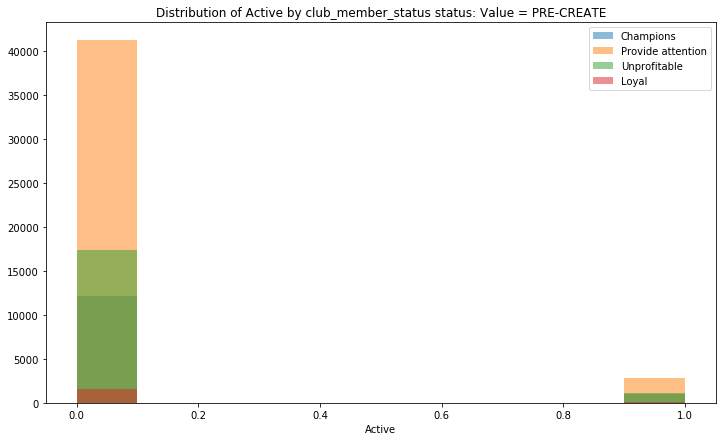

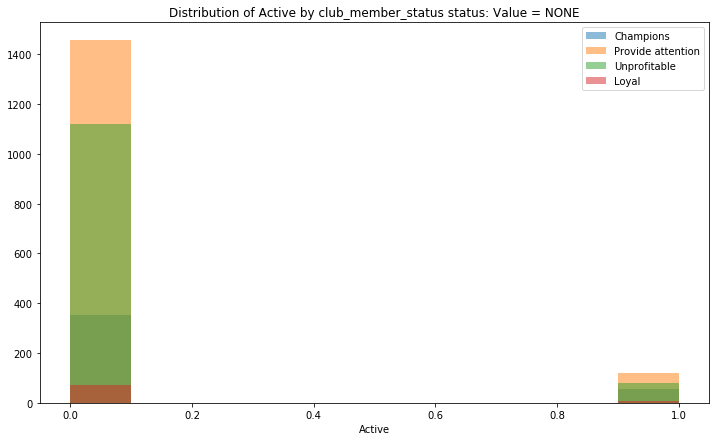

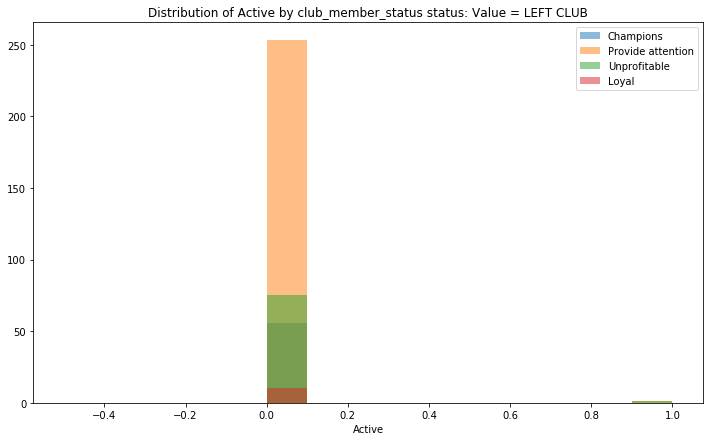

In [79]:
# For age column
common_col = 'Active'
col = 'club_member_status'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

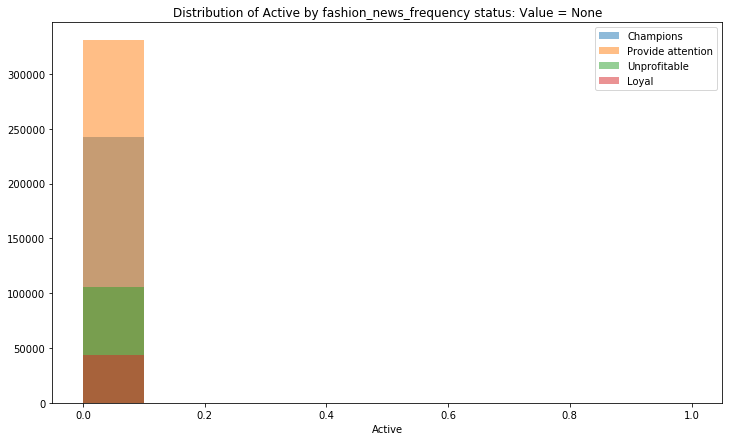

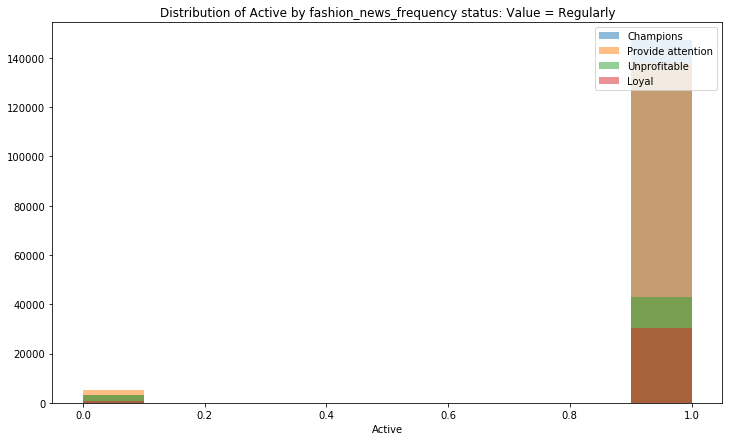

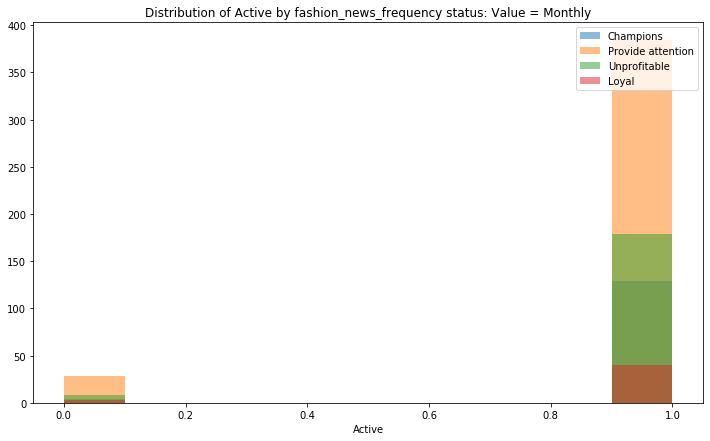

In [80]:
# For age column
common_col = 'Active'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

#### fashion_news_frequency vs club_member_status

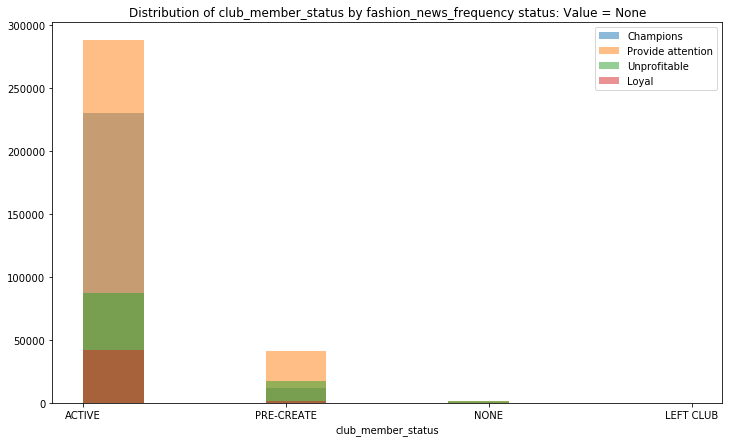

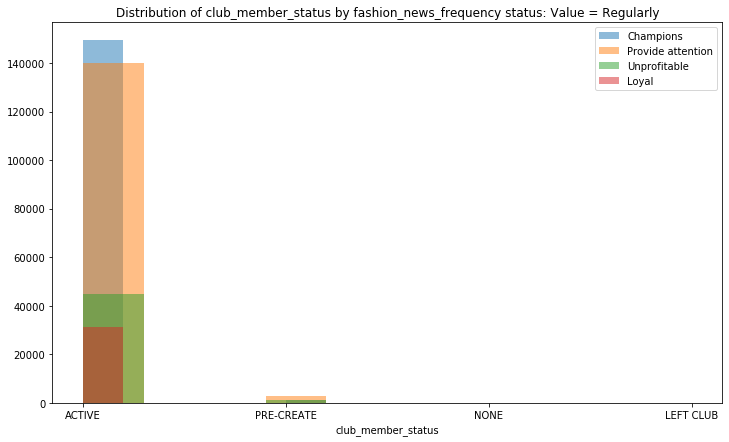

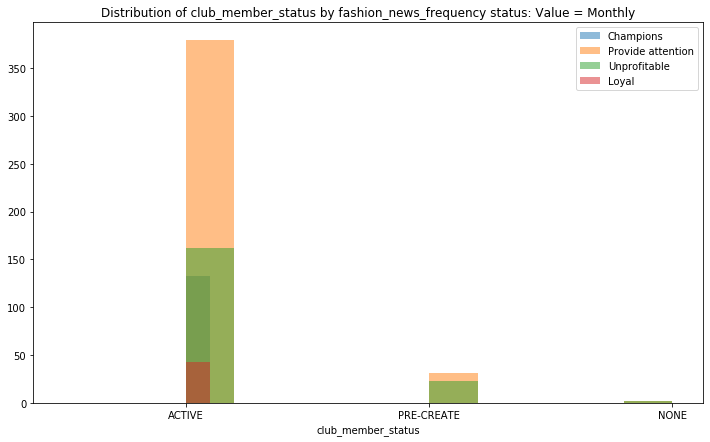

In [81]:
# For age column
common_col = 'club_member_status'
col = 'fashion_news_frequency'
for unique_item in rfm_customers[col].unique():
    plt.figure(figsize=(12,7))
    subset_by_item_df = rfm_customers[rfm_customers[col]==unique_item]
    
    for label in rfm_customers['rfm_label'].unique():
        subset_df = subset_by_item_df[subset_by_item_df['rfm_label']==label]
        plt.hist(common_col, data=subset_df, alpha=0.5, label=label)
    plt.title(f'Distribution of {common_col} by {col} status: Value = {unique_item}')
    plt.xlabel(f'{common_col}')
    plt.legend(bbox_to_anchor = (1, 1), loc='upper right')
    plt.show()

### 3.3.4 Purchase Behaviour Analysis of RFM Segments (with Transactions Data)

#### Read in CSV and Conduct Basic Analysis

In [82]:
articles = pd.read_csv('data/articles.csv')
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [83]:
articles = articles.loc[:,['article_id','prod_name','product_type_name','product_group_name',
                          'graphical_appearance_name','colour_group_name','perceived_colour_value_name',
                          'perceived_colour_master_name','department_name','index_name','index_group_name',
                          'section_name','garment_group_name']]
print('Dataframe shape:',articles.shape)
articles.head()

Dataframe shape: (105542, 13)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear"


In [84]:
# Basic data check: Check for null values
for col in articles.columns:
    print("Number of Null Values in", col, " : ", len(articles[articles[col].isna()]), "/", len(articles))

Number of Null Values in article_id  :  0 / 105542
Number of Null Values in prod_name  :  0 / 105542
Number of Null Values in product_type_name  :  0 / 105542
Number of Null Values in product_group_name  :  0 / 105542
Number of Null Values in graphical_appearance_name  :  0 / 105542
Number of Null Values in colour_group_name  :  0 / 105542
Number of Null Values in perceived_colour_value_name  :  0 / 105542
Number of Null Values in perceived_colour_master_name  :  0 / 105542
Number of Null Values in department_name  :  0 / 105542
Number of Null Values in index_name  :  0 / 105542
Number of Null Values in index_group_name  :  0 / 105542
Number of Null Values in section_name  :  0 / 105542
Number of Null Values in garment_group_name  :  0 / 105542


In [85]:
# Convert datatypes to suitable datatypes
articles = articles.astype({'article_id':'str',
                            'prod_name':'category',
                            'product_type_name':'category',
                            'product_group_name':'category',
                            'graphical_appearance_name':'category',
                            'colour_group_name':'category',
                            'perceived_colour_value_name':'category',
                            'perceived_colour_master_name':'category',
                            'department_name':'category',
                            'index_name':'category',
                            'index_group_name':'category',
                            'section_name':'category',
                            'garment_group_name':'category'})
articles.dtypes

article_id                        object
prod_name                       category
product_type_name               category
product_group_name              category
graphical_appearance_name       category
colour_group_name               category
perceived_colour_value_name     category
perceived_colour_master_name    category
department_name                 category
index_name                      category
index_group_name                category
section_name                    category
garment_group_name              category
dtype: object

In [86]:
# Merge Articles with Transaction Data on article_id (Transations data is df_new subsetted at the start)
article_transaction = articles.merge(df_new, on='article_id')

# Merge Article+Transaction with RFM Data on customer_id
rfm_article_transact = article_transaction.merge(df_rfm[['customer_id','Recency','Frequency','Monetary','rfm_label']], on='customer_id')

print('Dataframe shape:',rfm_article_transact.shape)
rfm_article_transact.head()

Dataframe shape: (10249803, 21)


,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,customer_id,t_dat,price,sales_channel_id,Recency,Frequency,Monetary,rfm_label
0,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,2018-09-20,0.005068,2,92,34,14.654536,Loyal
1,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,2018-09-20,0.005068,2,92,34,14.654536,Loyal
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,2018-09-20,0.005068,2,92,34,14.654536,Loyal
3,311059024,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Green,Bright,Green,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,2018-09-21,0.010153,2,92,34,14.654536,Loyal
4,311059026,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Red,Medium,Red,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,2018-09-21,0.011847,2,92,34,14.654536,Loyal


#### Remove irrelevant columns and put customer_id to the front of the dataframe

In [87]:
# Drop columns that are not needed
rfm_article_transact = rfm_article_transact.drop(['article_id','t_dat','Recency','Frequency','Monetary'], axis=1)

# Place customer_id in the 1st column
customer_id = rfm_article_transact['customer_id']
rfm_article_transact.drop(labels=['customer_id'], axis=1, inplace=True)
rfm_article_transact.insert(0, 'customer_id', customer_id)

rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
1,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
2,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
3,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Green,Bright,Green,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,0.010153,2,Loyal
4,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Red,Medium,Red,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,0.011847,2,Loyal


#### Purchase Behaviour Analysis 1: Descriptive analysis

In [88]:
rfm_article_transact.groupby('rfm_label')['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
               'perceived_colour_value_name','perceived_colour_master_name','department_name',
               'index_name','index_group_name','section_name','garment_group_name','sales_channel_id'].describe()

prod_name                                     \
                      count unique                  top   freq   
rfm_label                                                        
Champions           5534102  38930            Despacito  13322   
Loyal                898081  28881              1pk Fun   2934   
Provide attention   3267133  35733            Despacito  10063   
Unprofitable         550487  22390  Panda skate dress j   2035   

                  product_type_name                          \
                              count unique      top    freq   
rfm_label                                                     
Champions                   5534102    130    Dress  667101   
Loyal                        898081    123  T-shirt   94919   
Provide attention           3267133    125  Sweater  404495   
Unprofitable                 550487    110  T-shirt   62958   

                  graphical_appearance_name                         \
                                      count unique    top     freq   
rfm_label                                                            
Champions                           5534102     30  Solid  2954907   
Loyal                                898081     30  Solid   466678   
Provide attention                   3267133     30  Solid  1625722   
Unprofitable                         550487     29  Solid   248835   

                  colour_group_name                         \
                              count unique    top     freq   
rfm_label                                                    
Champions                   5534102     50  Black  1626607   
Loyal                        898081     50  Black   242111   
Provide attention           3267133     50  Black   999085   
Unprofitable                 550487     50  Black   137591   

                  perceived_colour_value_name                        \
                                        count unique   top     freq   
rfm_label                                                             
Champions                             5534102      8  Dark  2439241   
Loyal                                  898081      8  Dark   367316   
Provide attention                     3267133      8  Dark  1593314   
Unprofitable                           550487      8  Dark   241187   

                  perceived_colour_master_name                         \
                                         count unique    top     freq   
rfm_label                                                               
Champions                              5534102     20  Black  1616813   
Loyal                                   898081     20  Black   240716   
Provide attention                      3267133     20  Black   988620   
Unprofitable                            550487     19  Black   135939   

                  department_name                          index_name         \
                            count unique       top    freq      count unique   
rfm_label                                                                      
Champions                 5534102    245  Swimwear  365010    5534102     10   
Loyal                      898081    244  Swimwear   64837     898081     10   
Provide attention         3267133    248  Knitwear  218554    3267133     10   
Unprofitable               550487    239  Swimwear   32045     550487     10   

                                       index_group_name                     \
                          top     freq            count unique         top   
rfm_label                                                                    
Champions          Ladieswear  2326312          5534102      5  Ladieswear   
Loyal              Ladieswear   258439           898081      5  Ladieswear   
Provide attention  Ladieswear  1293607          3267133      5  Ladieswear   
Unprofitable       Ladieswear   136337           550487      5  Ladieswear   

                           section_name                              

#### Purchase Behaviour Analysis 2: Analysis of purchase behaviour by segments (Bottom 2 analyses are the same just displayed in different sequences)

#### - Purchase Behaviour Analysis 2.1: Compare purchase behaviour within RFM segments (Same as Graphical Analysis but in number form)

In [89]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### - Purchase Behaviour Analysis 2.2: Compare purchase behaviour across RFM segments (Same as Graphical Analysis but in number form)

In [90]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#     print('----- Column:',col,'-----')
#     for label in labels:
#         print('RFM Segment:',label)
#         subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0]
#         if len(value_counts) > 10:
#             print(value_counts[:10])
#         else:
#             print(value_counts)
#         print('\n')

#### Purchase Behaviour Analysis 3: Graphical Analysis for the different RFM Segments (Bottom 2 analyses are the same just displayed in different sequences)

In [91]:
def barplot(df, segment, var_col, xticklabels, rotate=False):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.bar(xticklabels, df[var_col])
    for p in ax.patches:
        ax.annotate(p.get_height(), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 10), 
                    textcoords='offset points')

    ax.set_xticklabels(xticklabels)
    if rotate:
        plt.xticks(rotation=45)

    max_height = max([x.get_height() for x in ax.patches])    
    plt.ylim(0, max_height*1.25)
    plt.title(f'Bar chart of {var_col} for {segment}')
    plt.show()

#### - Purchase Behaviour Analysis 3.1: View graphs by RFM Segments (Compare within RFM Segments) [Based on Top 10 categories]

In [92]:
# # Based on Top 10 categories in each column variable
# labels = list(rfm_article_transact['rfm_label'].unique())
# for label in labels:
#     print('----- RFM Segment:',label,'-----')
#     subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
#     for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
#                'perceived_colour_value_name','perceived_colour_master_name','department_name',
#                'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
#         print('Column:',col)
#         value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
#         if len(value_counts) > 10:
#             value_counts = value_counts[:10]
#         barplot(value_counts, label, col, value_counts.index, rotate=True)
#         print('\n')

#### - Purchase Behaviour Analysis 3.2: View graphs by Variables (Compare across RFM Segments)

----- Variable: prod_name -----
RFM Segment: Loyal


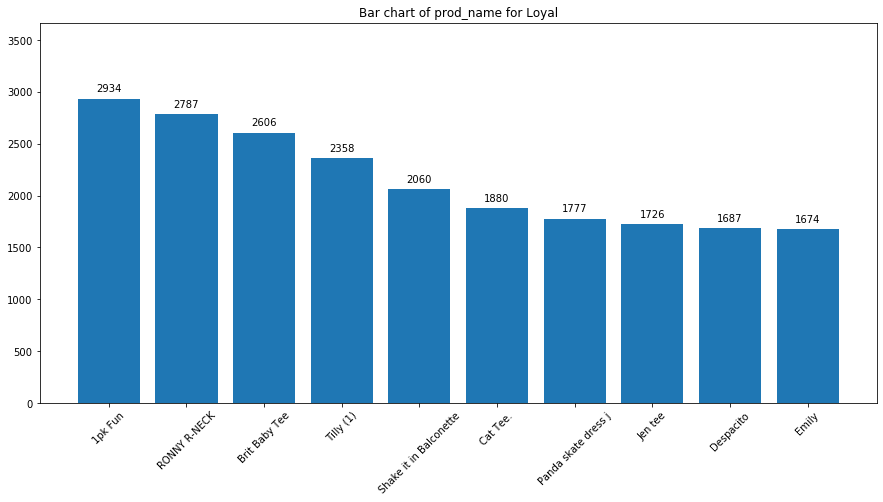



RFM Segment: Unprofitable


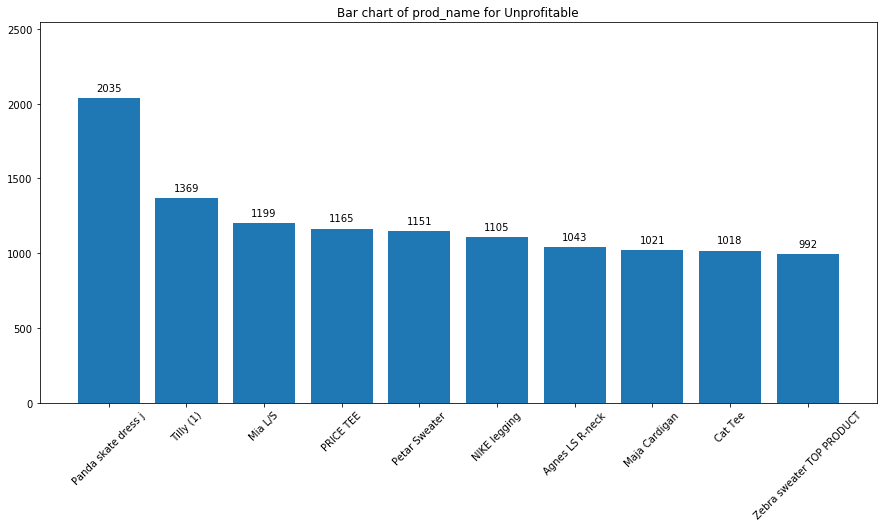



RFM Segment: Provide attention


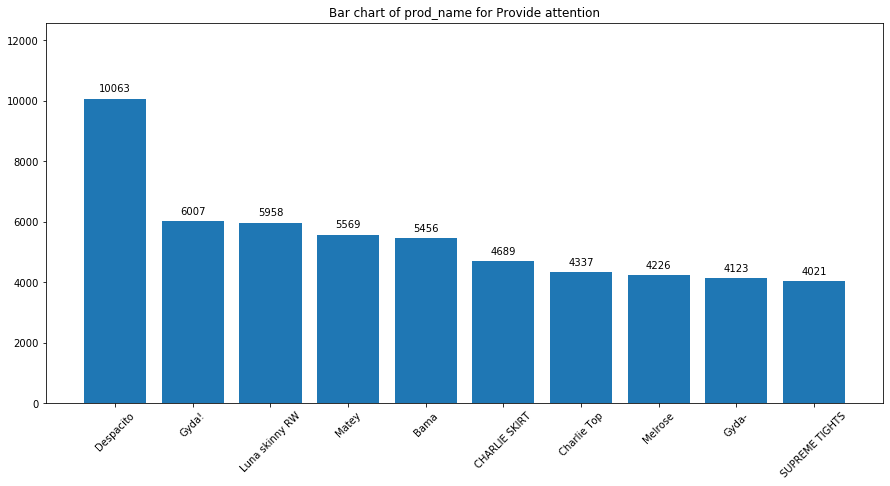



RFM Segment: Champions


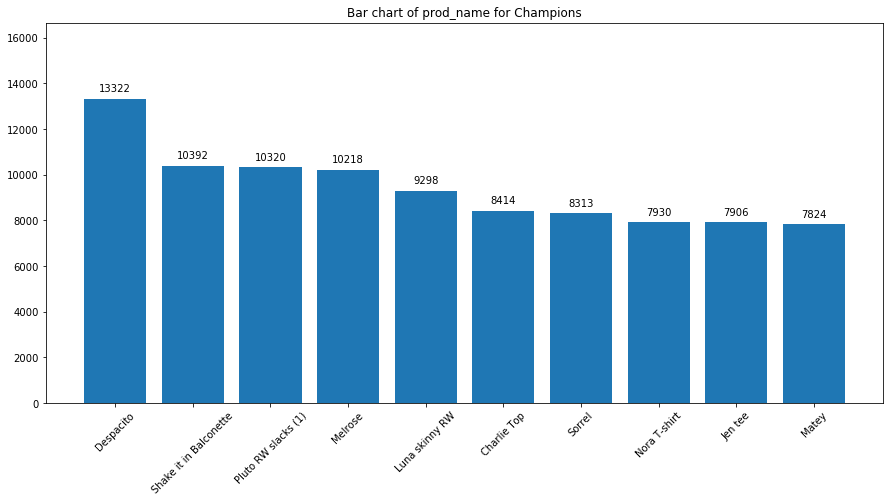



----- Variable: product_type_name -----
RFM Segment: Loyal


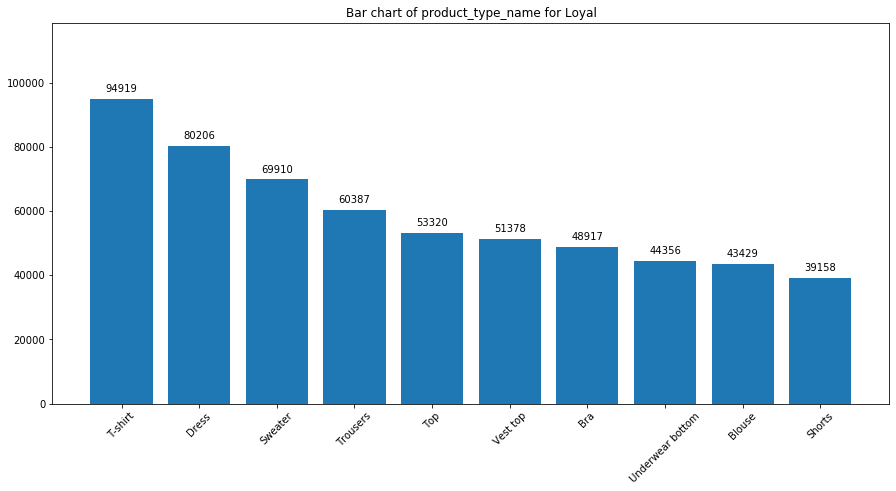



RFM Segment: Unprofitable


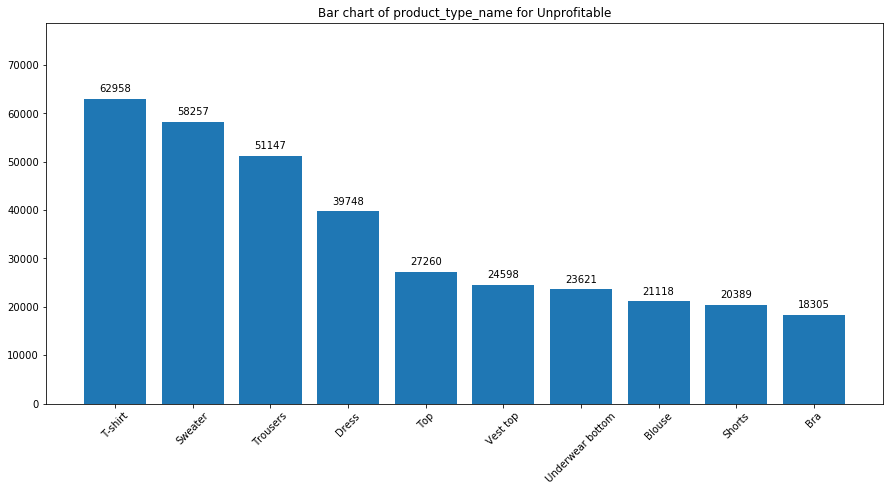



RFM Segment: Provide attention


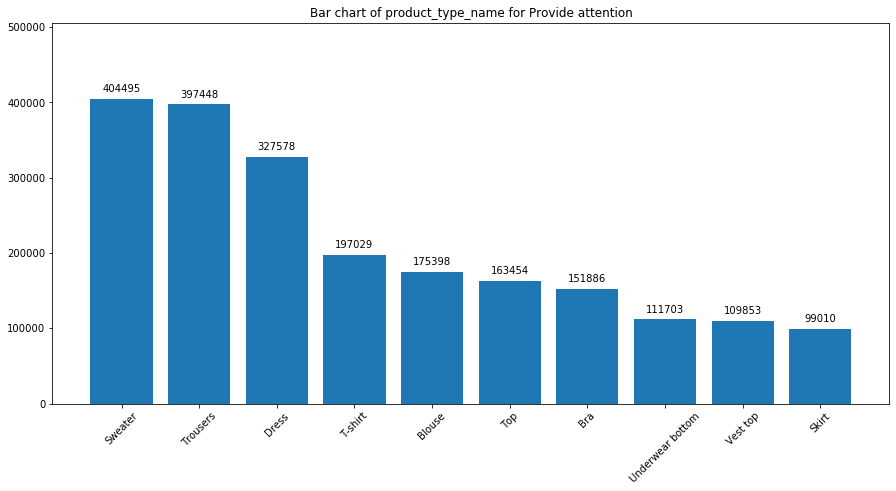



RFM Segment: Champions


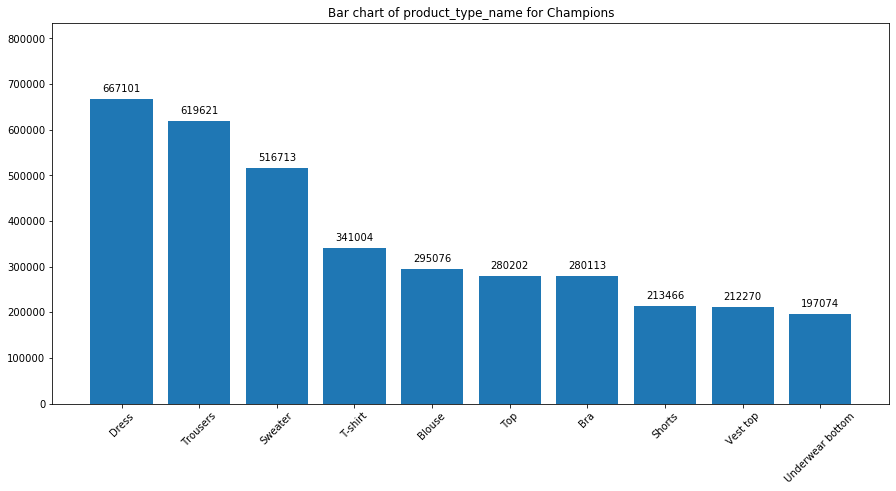



----- Variable: graphical_appearance_name -----
RFM Segment: Loyal


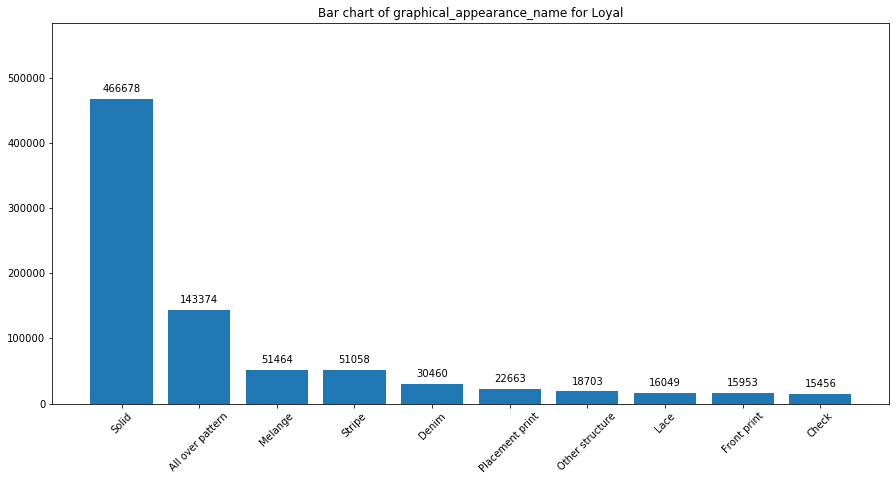



RFM Segment: Unprofitable


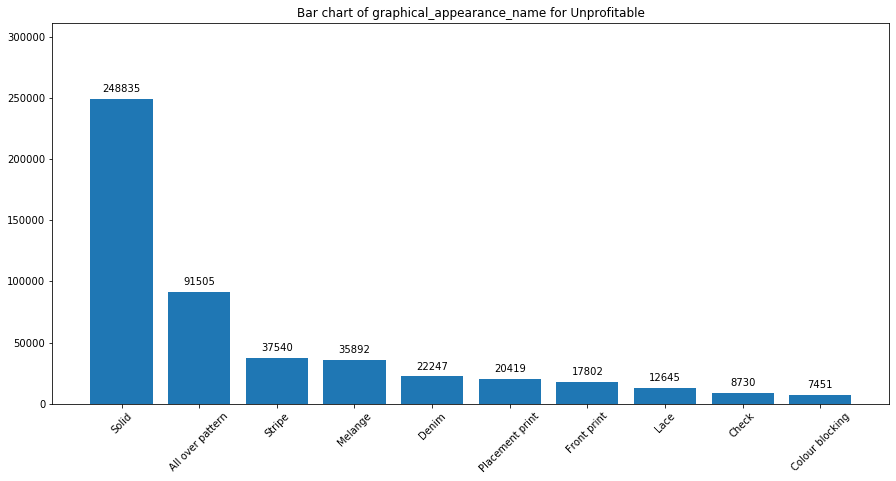



RFM Segment: Provide attention


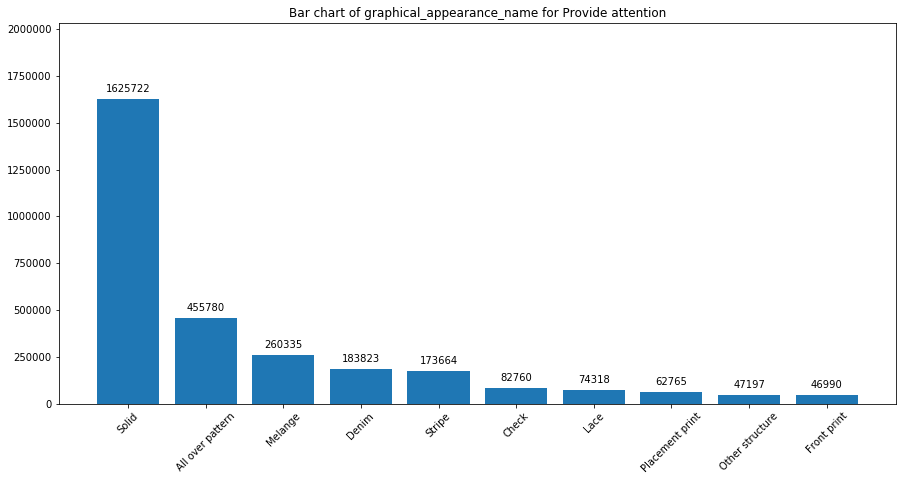



RFM Segment: Champions


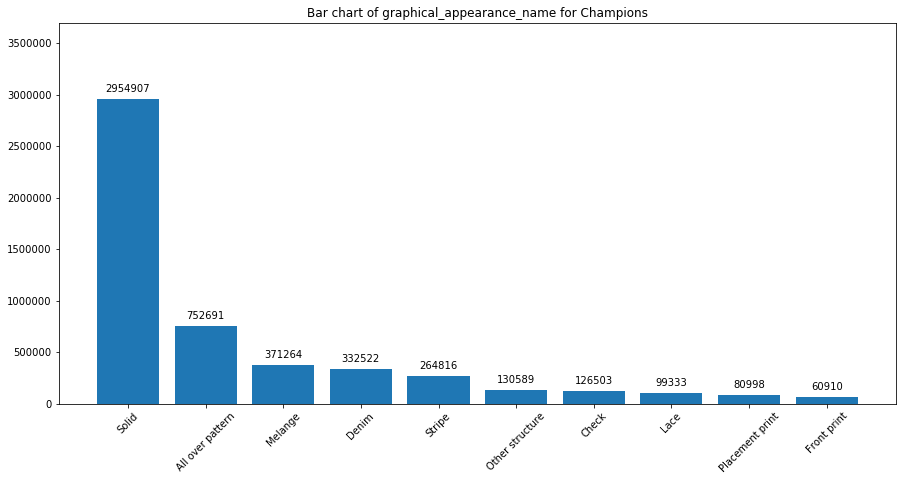



----- Variable: colour_group_name -----
RFM Segment: Loyal


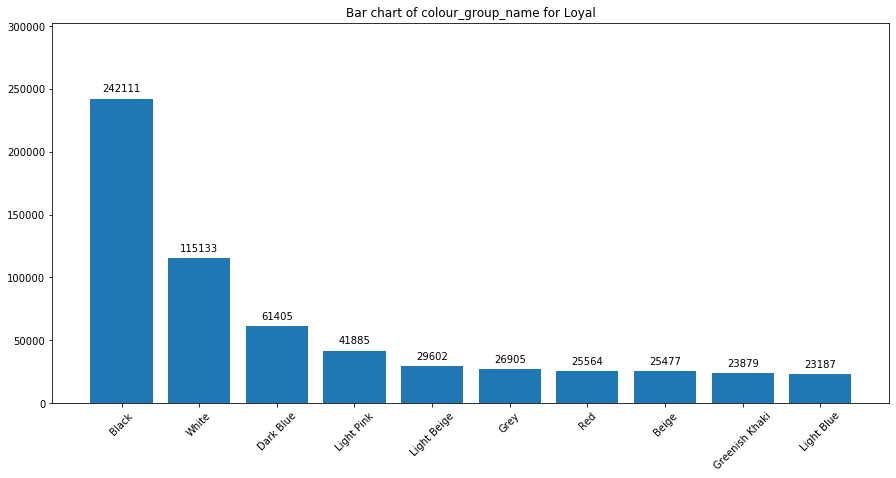



RFM Segment: Unprofitable


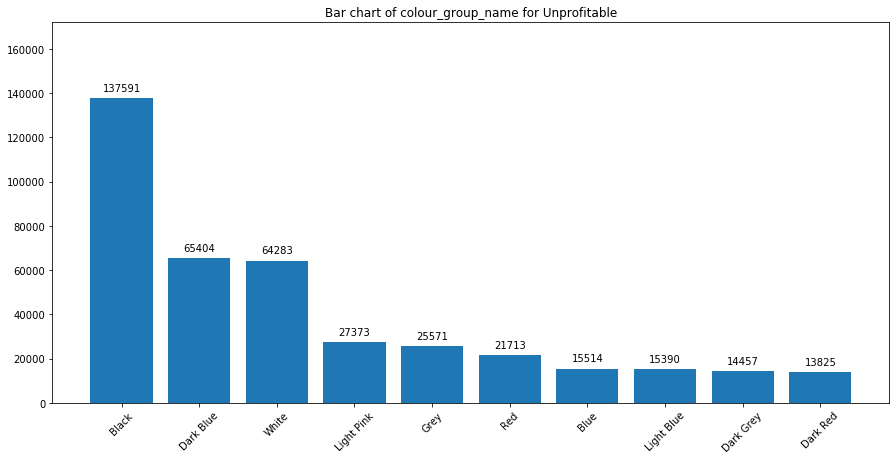



RFM Segment: Provide attention


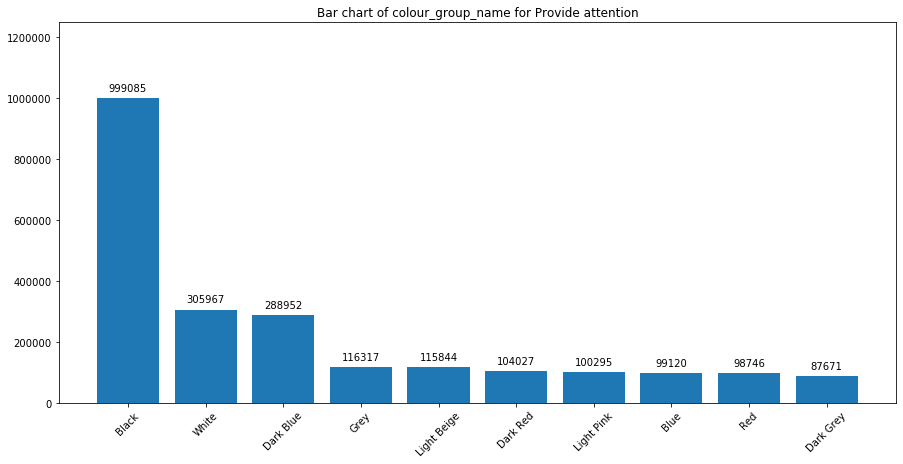



RFM Segment: Champions


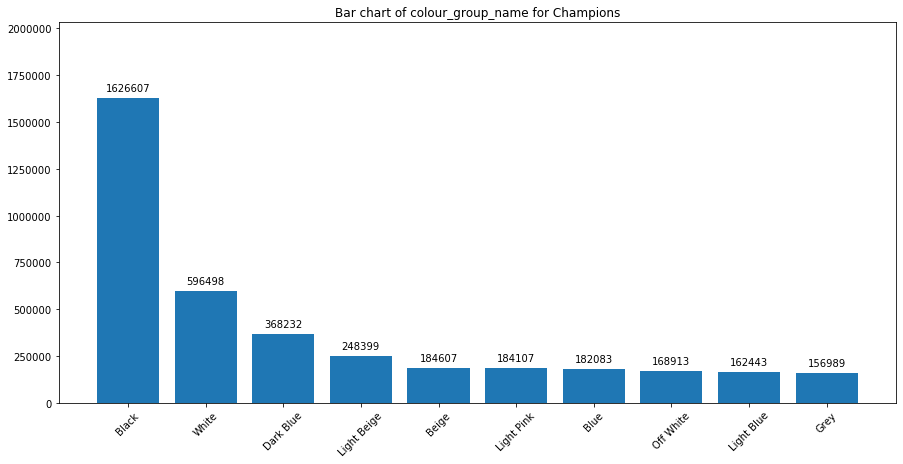



----- Variable: perceived_colour_value_name -----
RFM Segment: Loyal


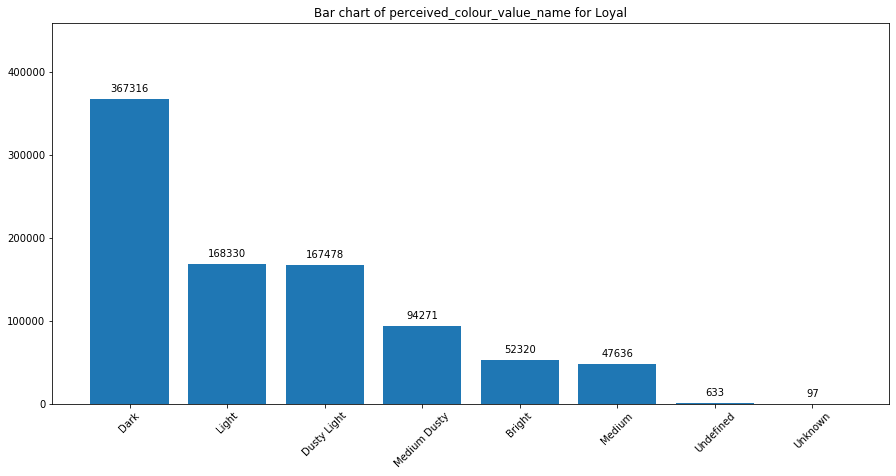



RFM Segment: Unprofitable


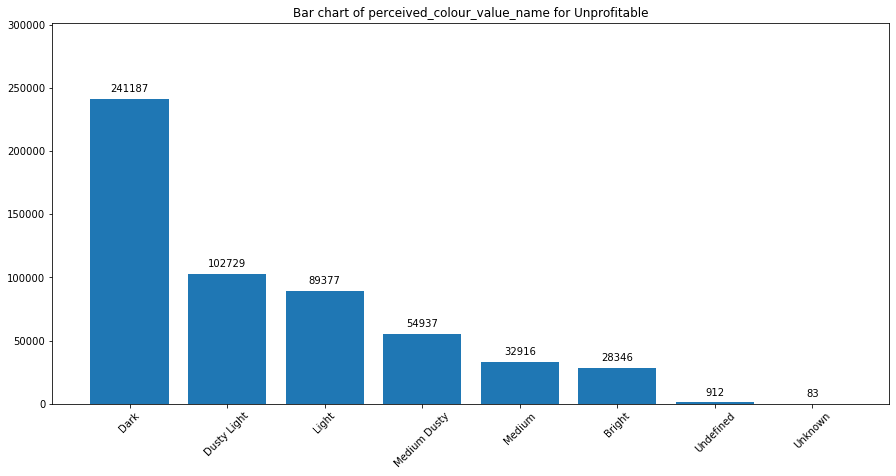



RFM Segment: Provide attention


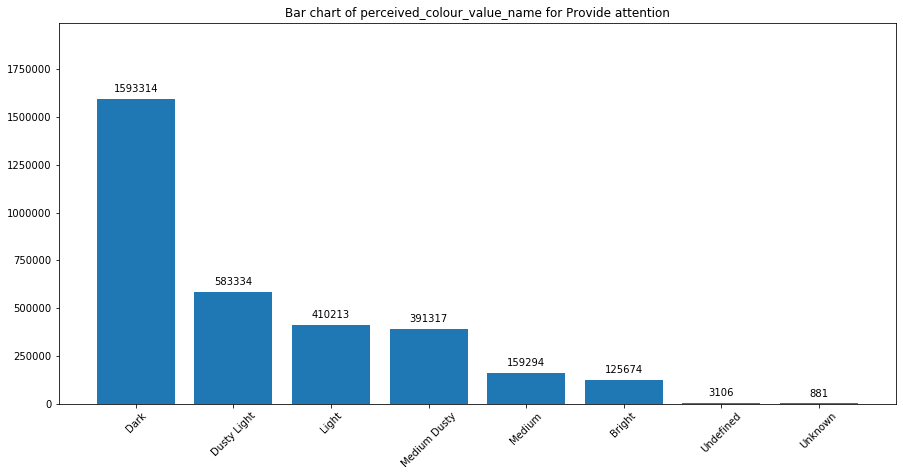



RFM Segment: Champions


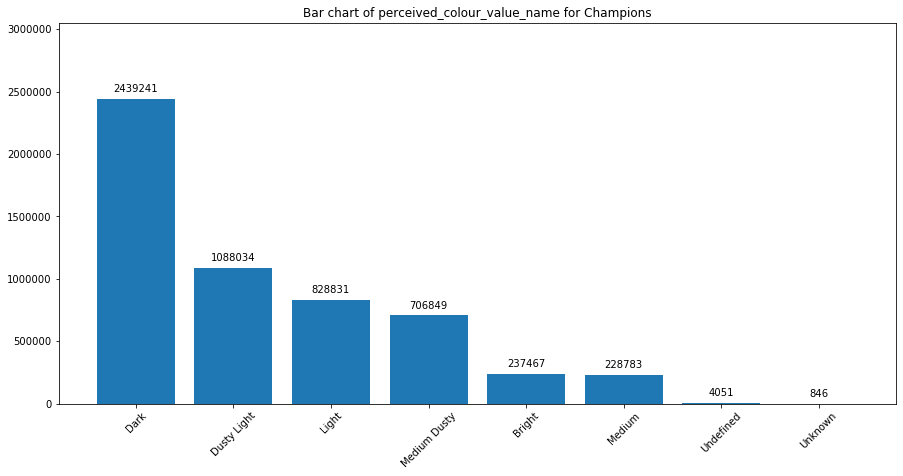



----- Variable: perceived_colour_master_name -----
RFM Segment: Loyal


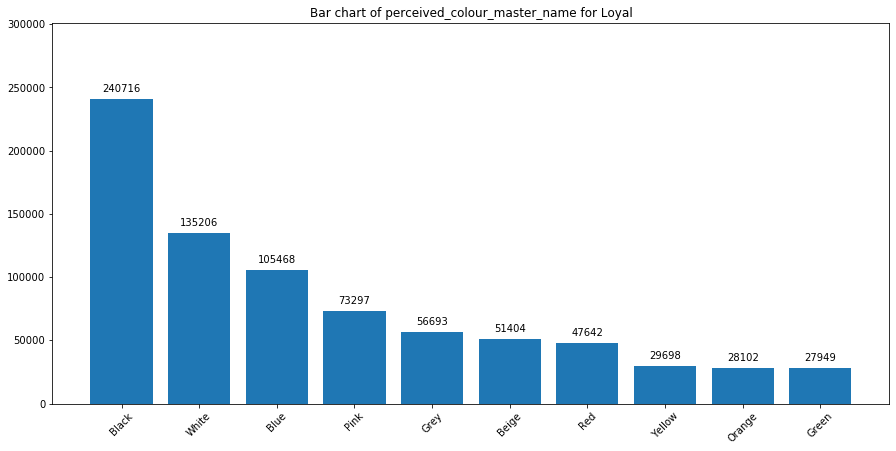



RFM Segment: Unprofitable


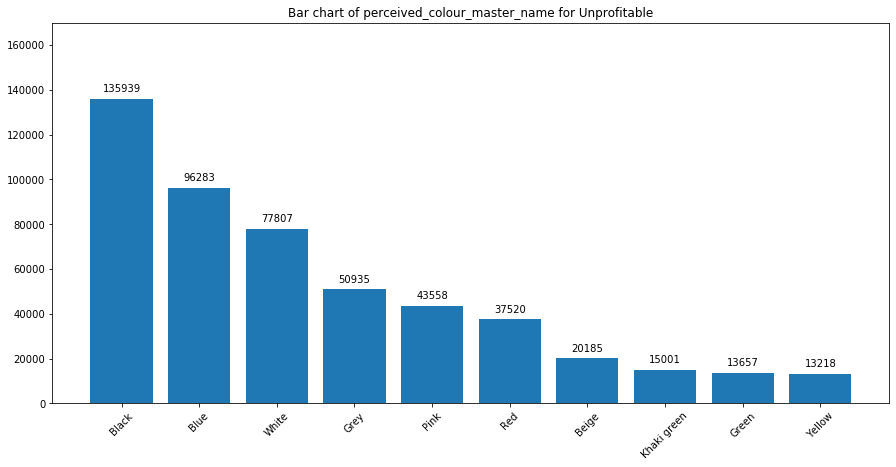



RFM Segment: Provide attention


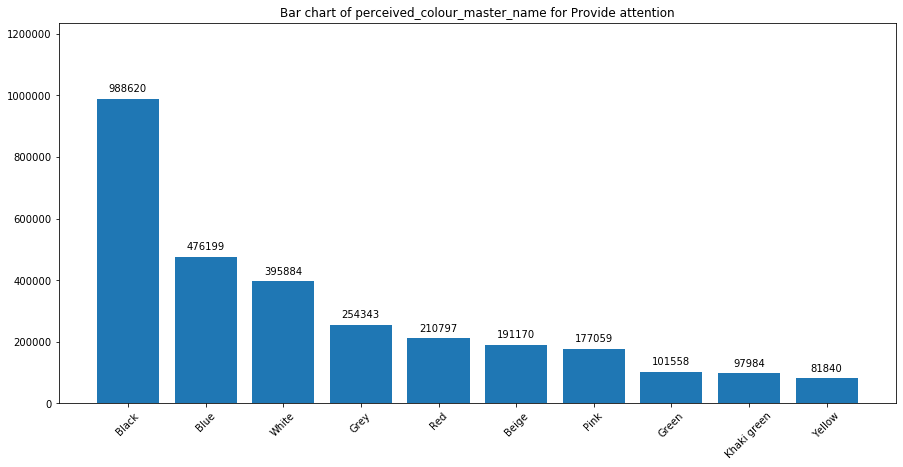



RFM Segment: Champions


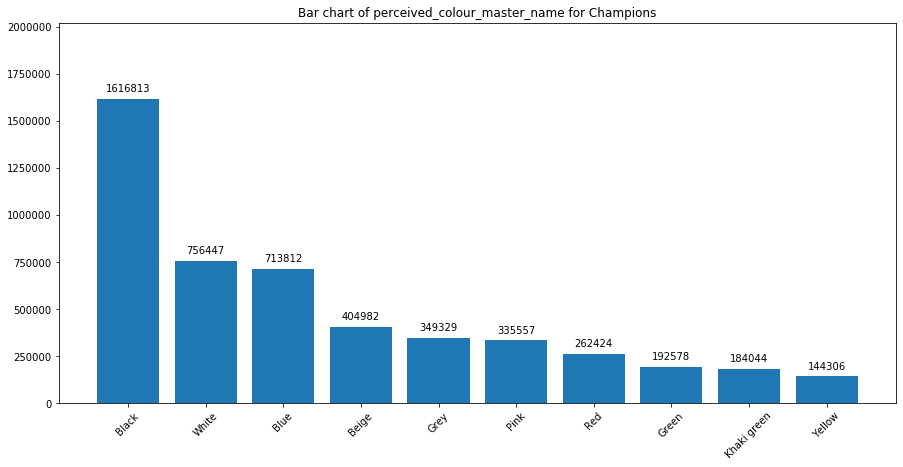



----- Variable: department_name -----
RFM Segment: Loyal


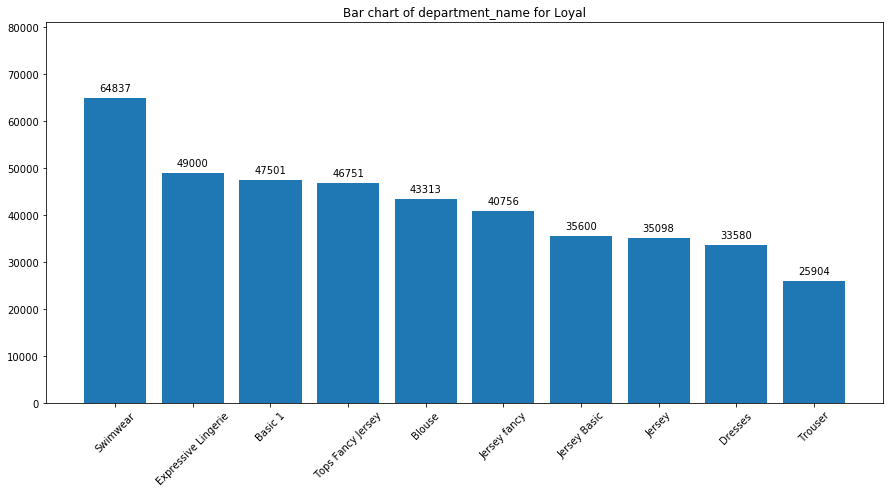



RFM Segment: Unprofitable


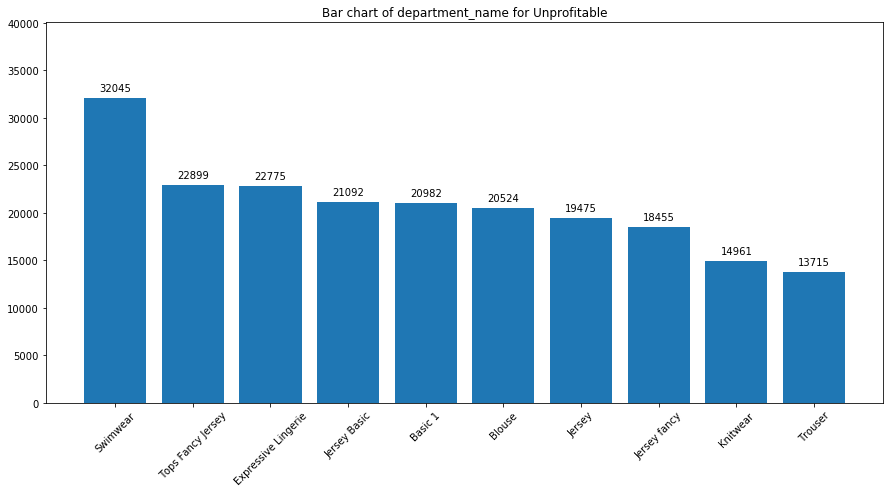



RFM Segment: Provide attention


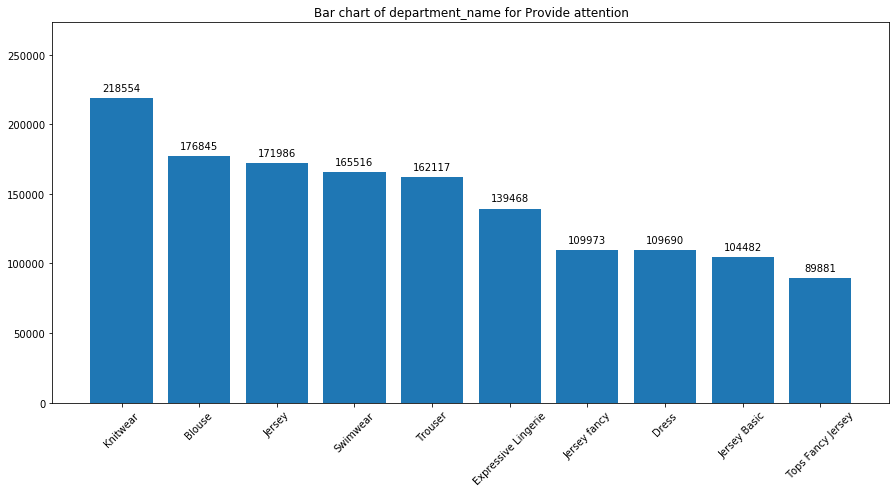



RFM Segment: Champions


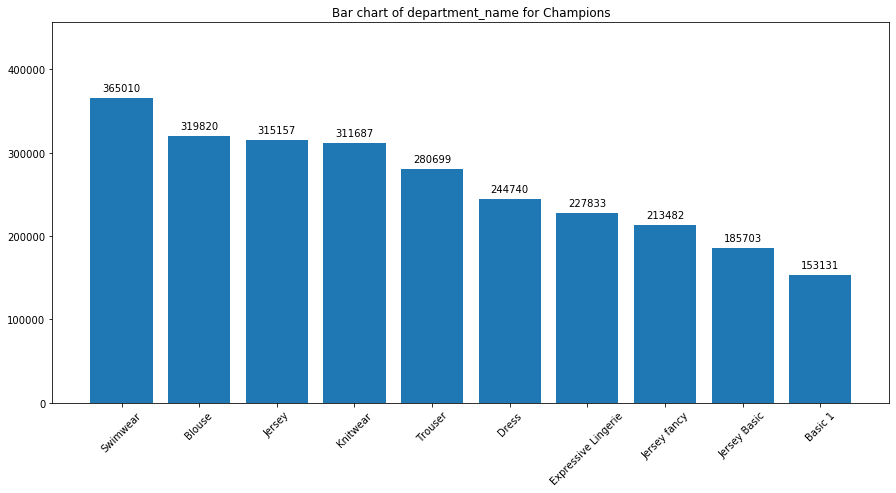



----- Variable: index_name -----
RFM Segment: Loyal


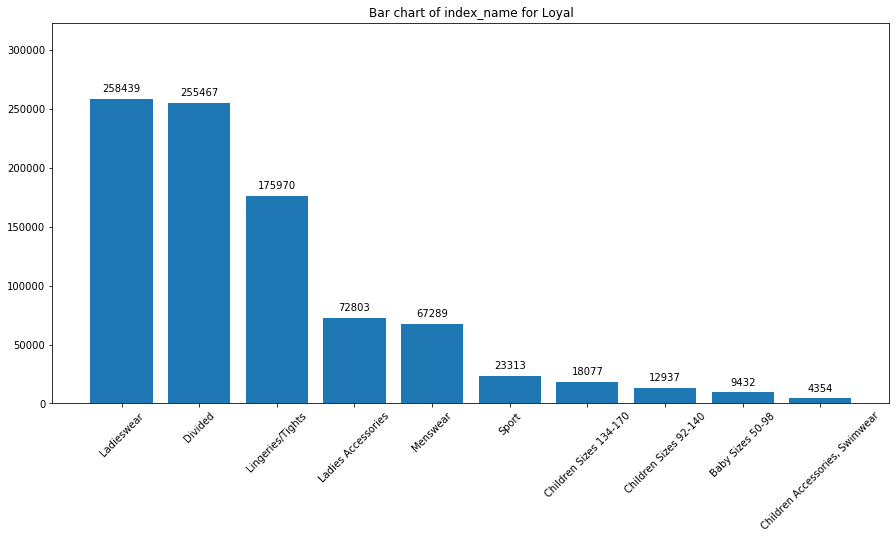



RFM Segment: Unprofitable


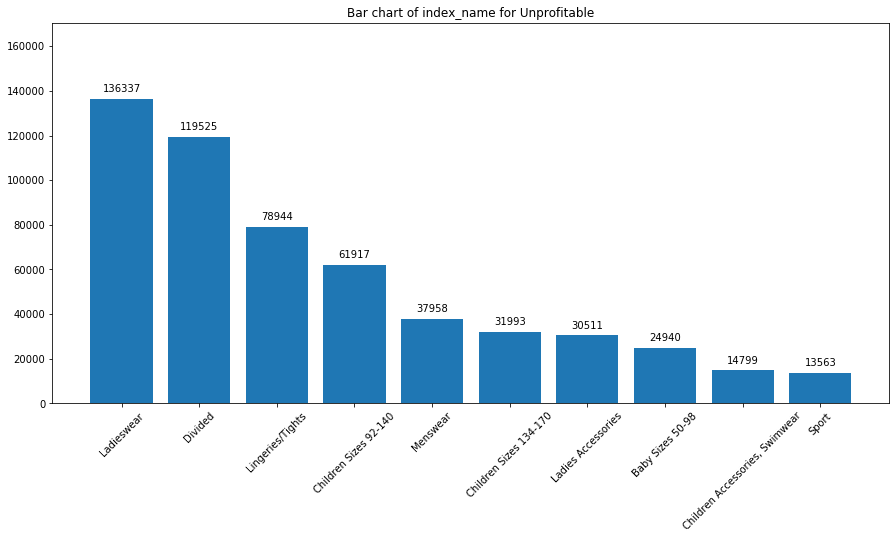



RFM Segment: Provide attention


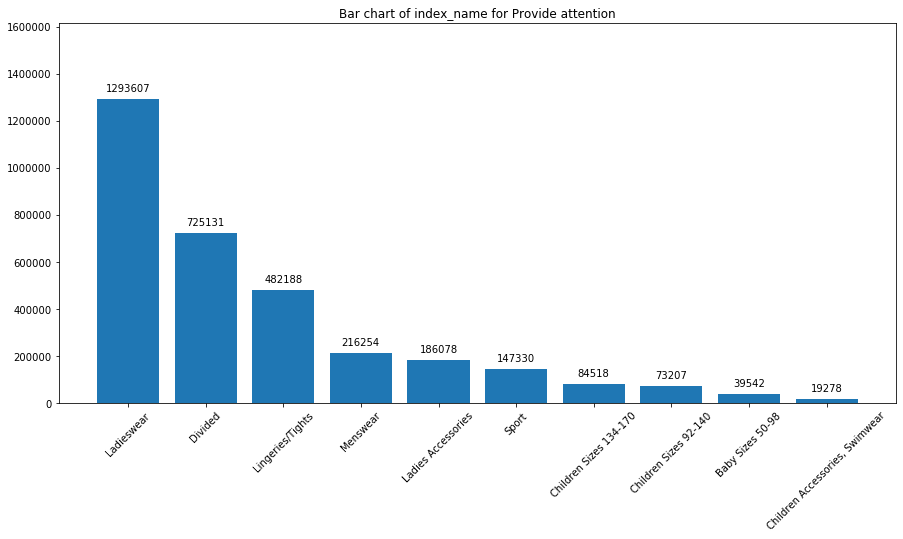



RFM Segment: Champions


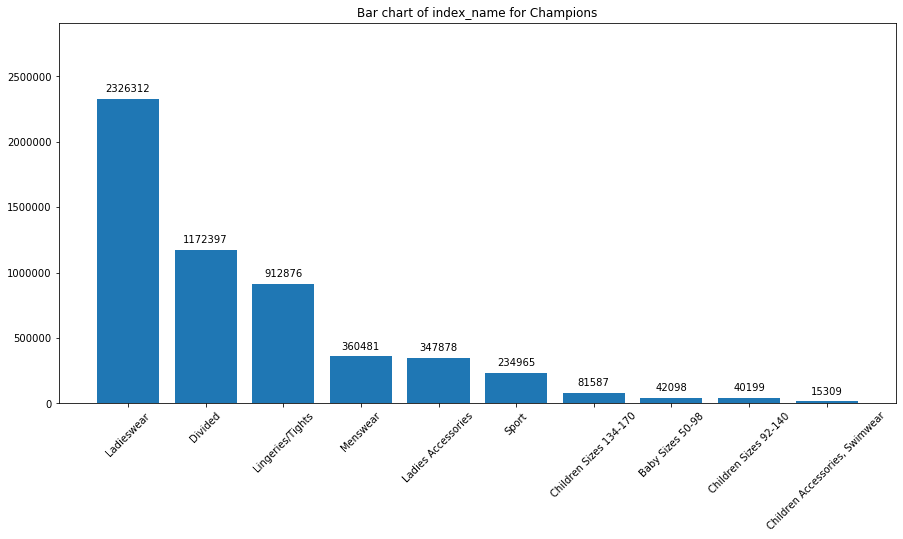



----- Variable: index_group_name -----
RFM Segment: Loyal


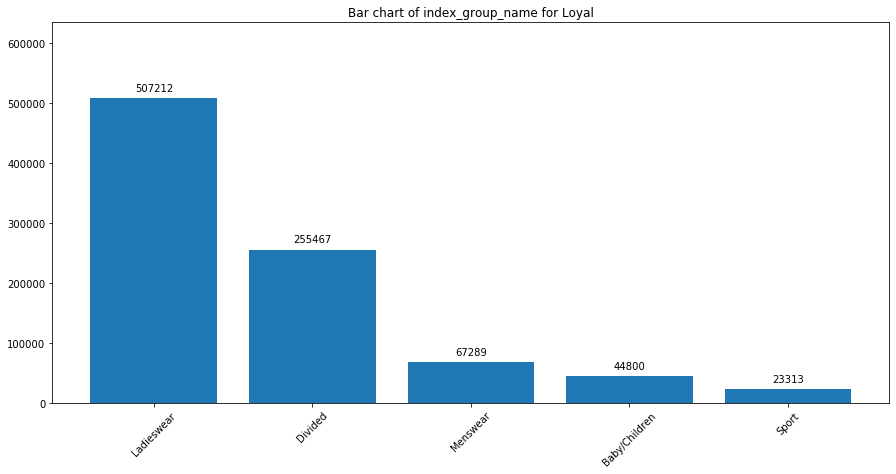



RFM Segment: Unprofitable


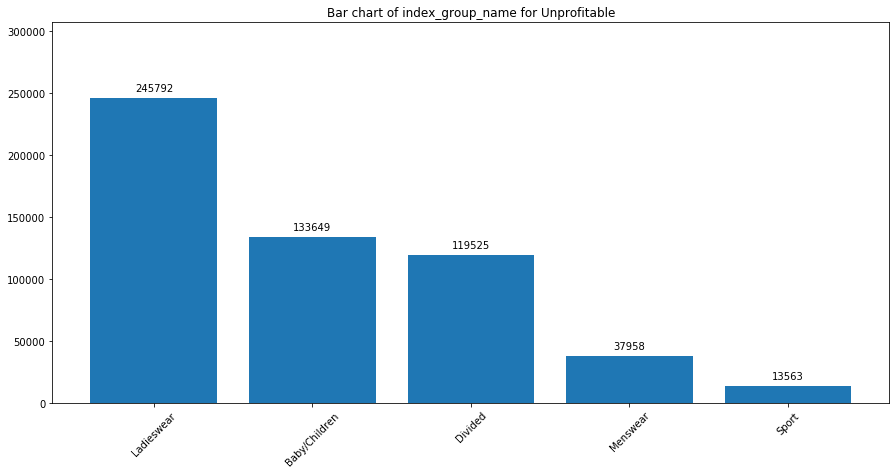



RFM Segment: Provide attention


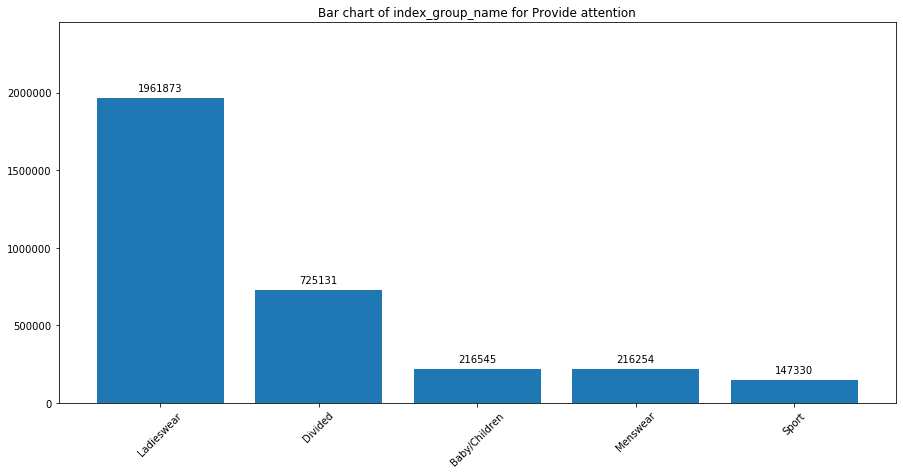



RFM Segment: Champions


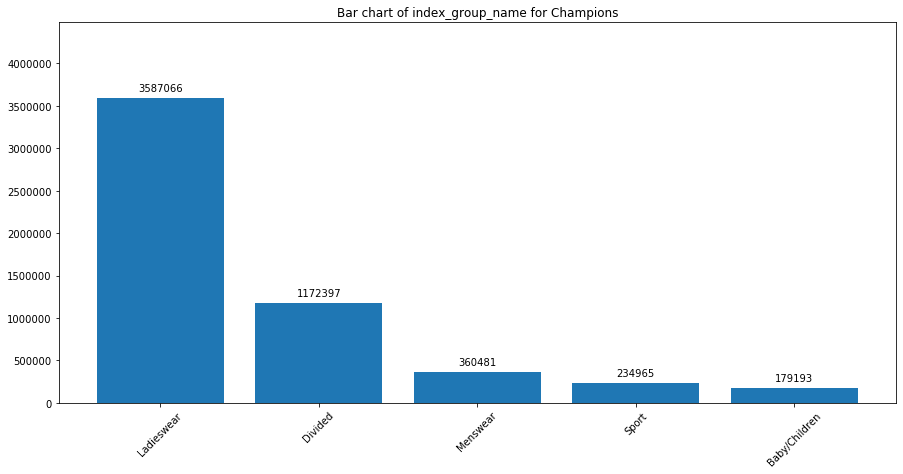



----- Variable: section_name -----
RFM Segment: Loyal


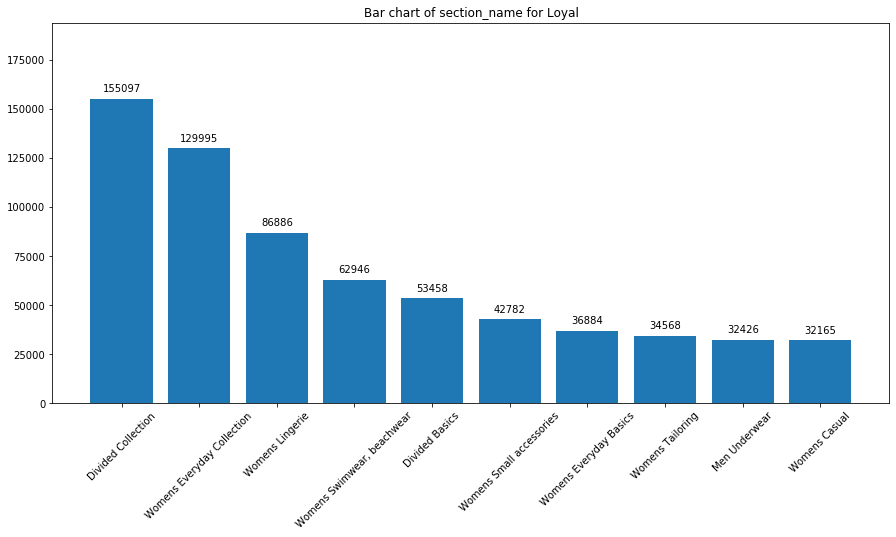



RFM Segment: Unprofitable


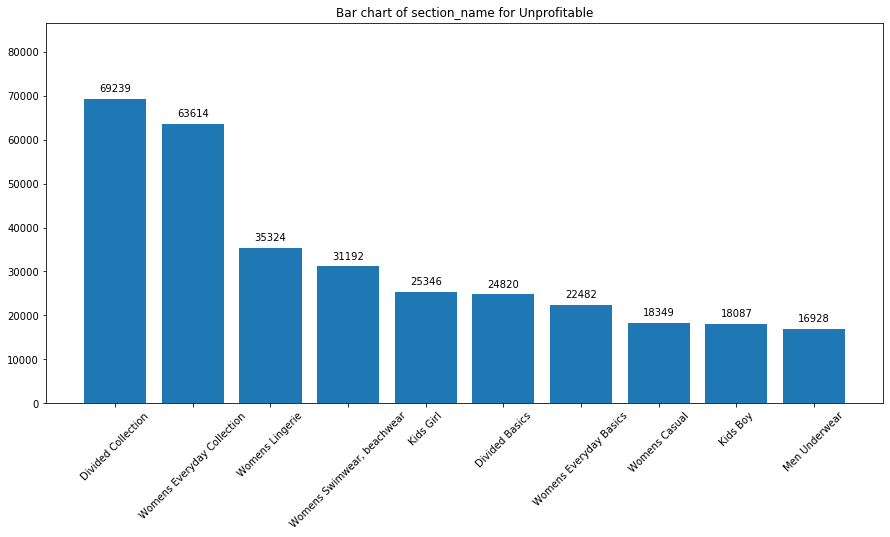



RFM Segment: Provide attention


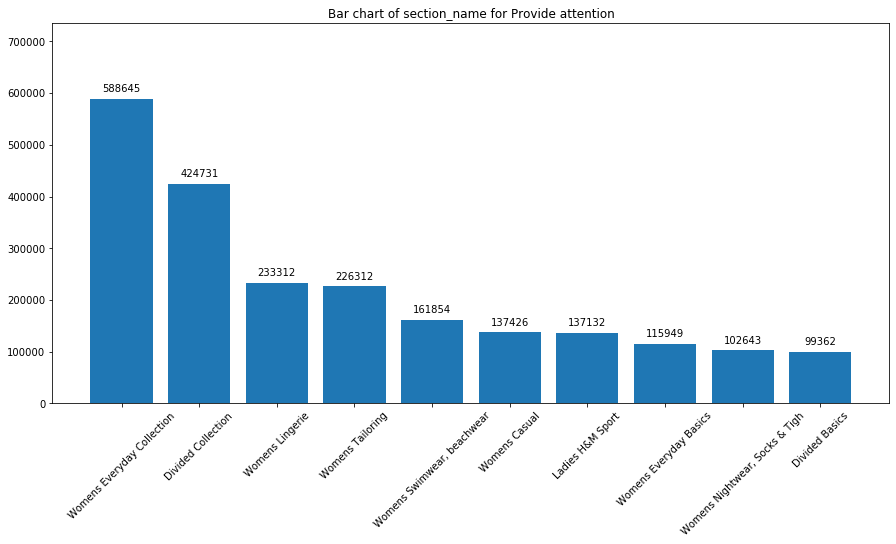



RFM Segment: Champions


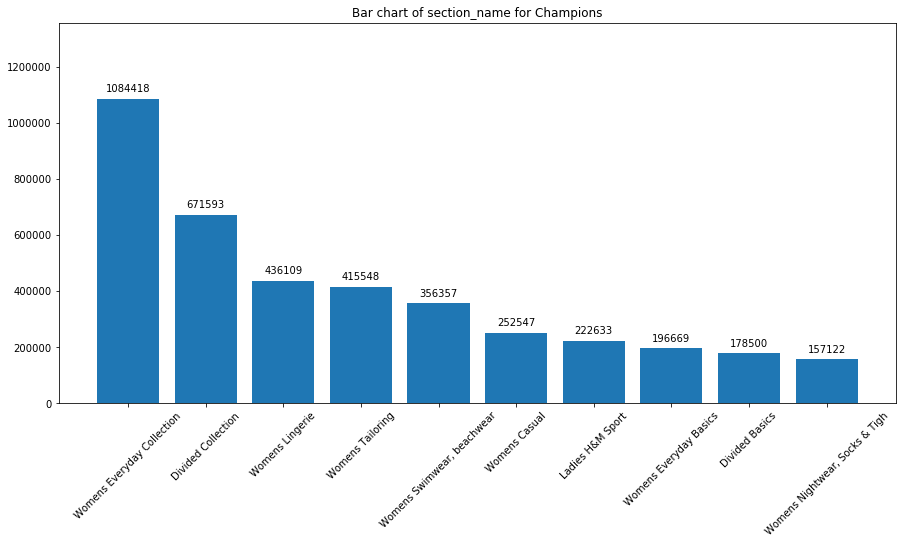



----- Variable: garment_group_name -----
RFM Segment: Loyal


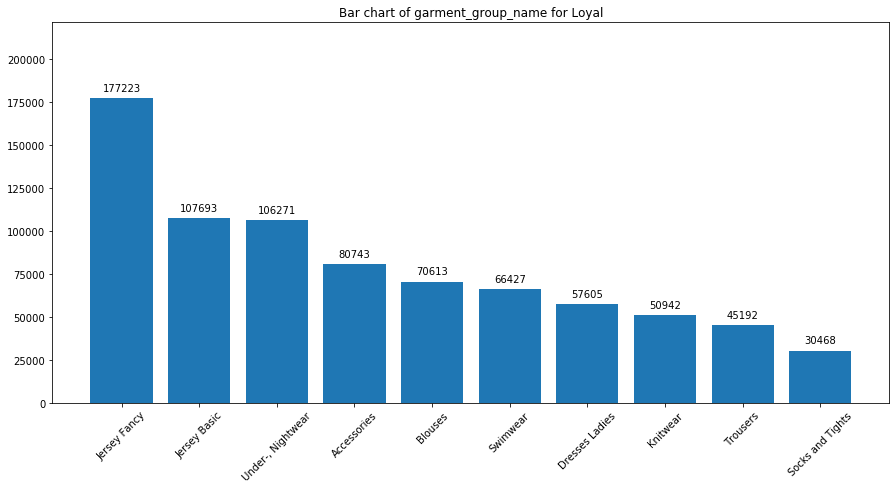



RFM Segment: Unprofitable


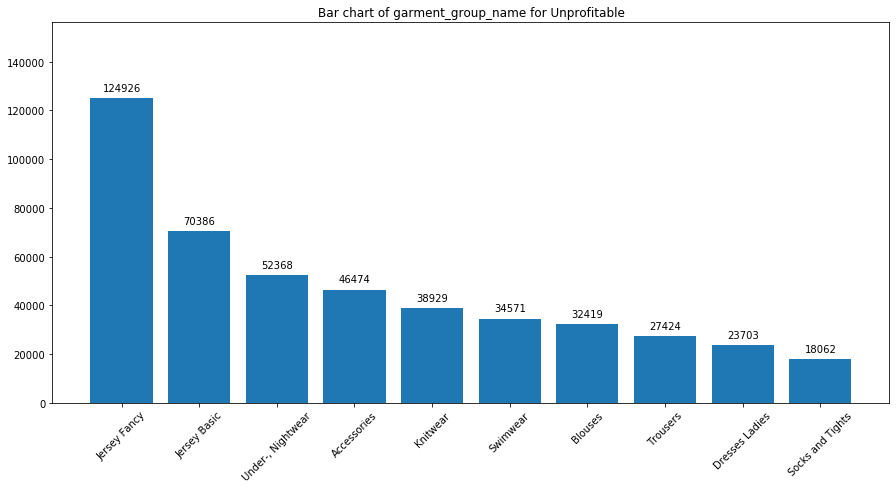



RFM Segment: Provide attention


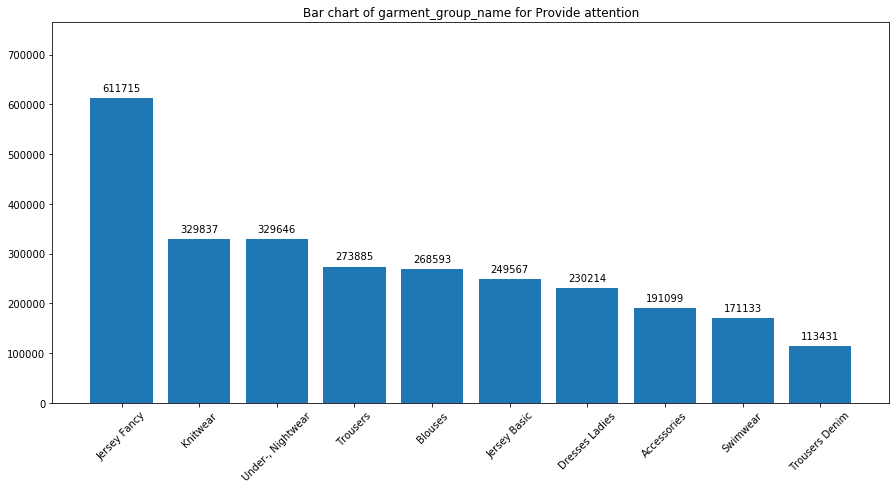



RFM Segment: Champions


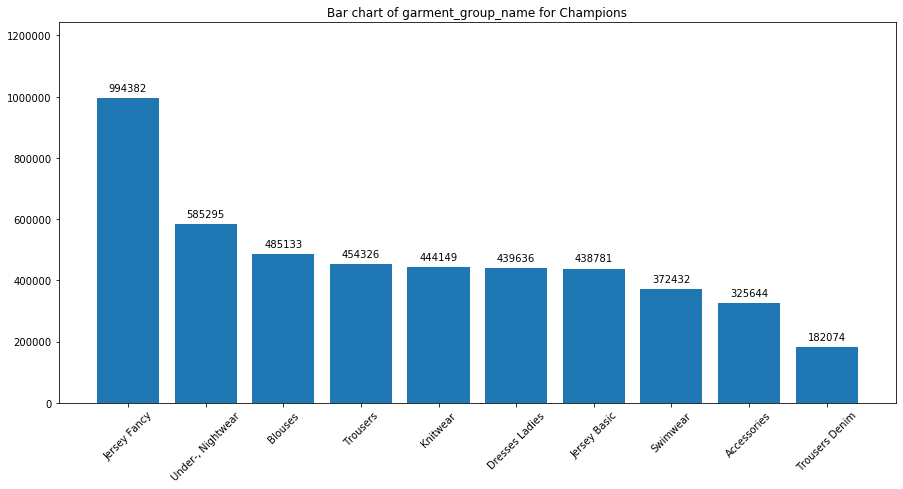



----- Variable: sales_channel_id -----
RFM Segment: Loyal


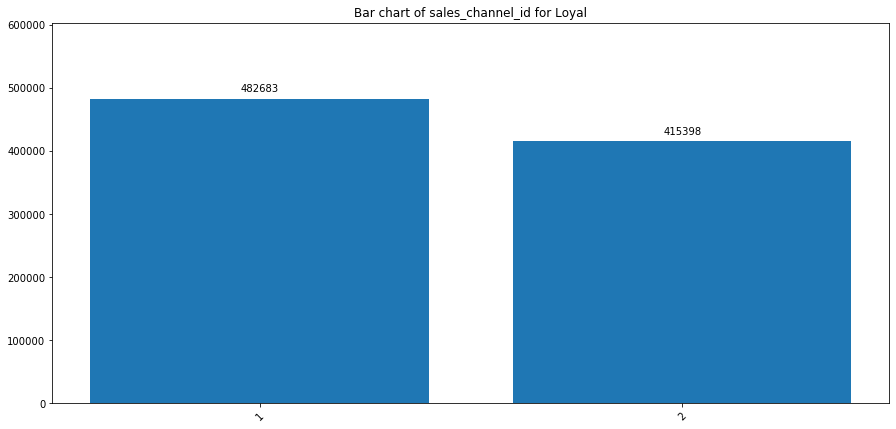



RFM Segment: Unprofitable


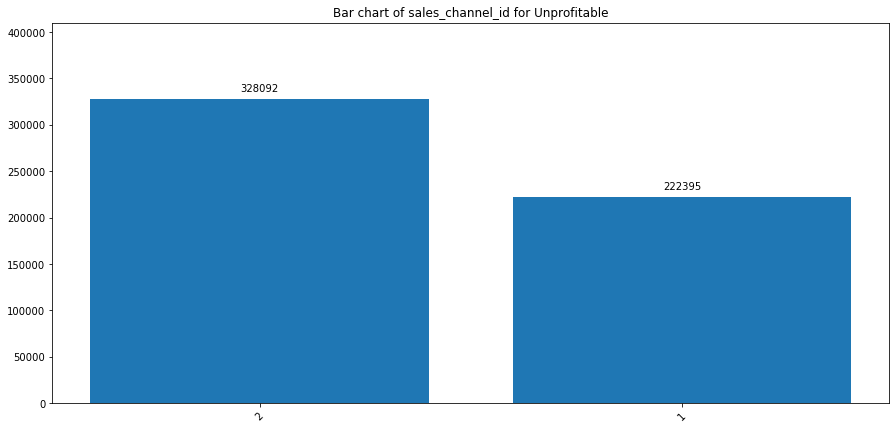



RFM Segment: Provide attention


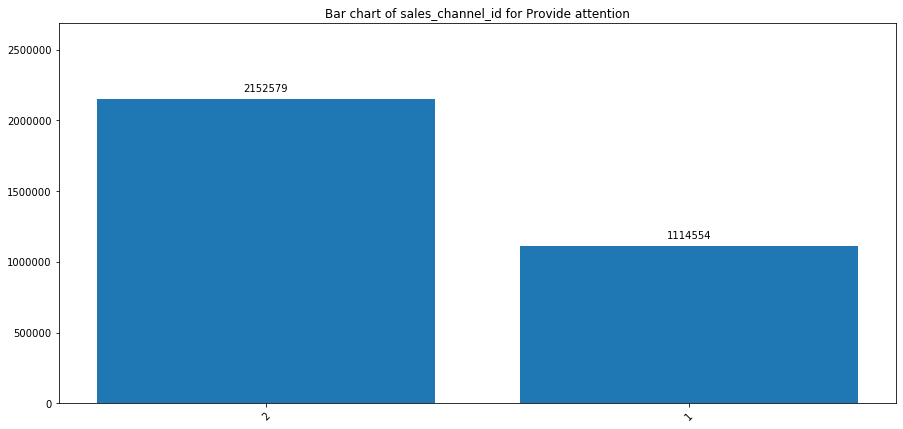



RFM Segment: Champions


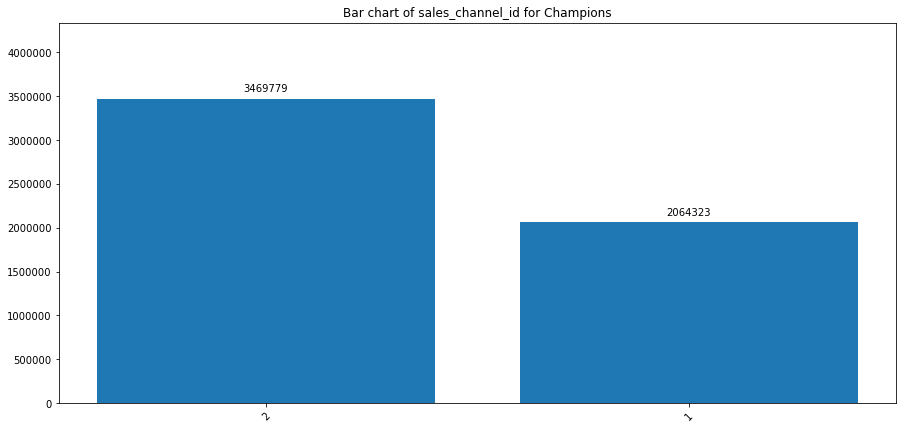

In [93]:
# Based on Top 10 categories in each column variable
labels = list(rfm_article_transact['rfm_label'].unique())
for col in ['prod_name','product_type_name','graphical_appearance_name','colour_group_name',
           'perceived_colour_value_name','perceived_colour_master_name','department_name',
           'index_name','index_group_name','section_name','garment_group_name','sales_channel_id']:
    print('----- Variable:',col,'-----')
    for label in labels:
        print('RFM Segment:',label)
        subset_df = rfm_article_transact[rfm_article_transact['rfm_label']==label]
        value_counts = subset_df[col].value_counts().loc[lambda x: x>0].to_frame()
        if len(value_counts) > 10:
            value_counts = value_counts[:10]
        barplot(value_counts, label, col, value_counts.index, rotate=True)
        print('\n')

#### Others

In [94]:
rfm_article_transact.head()

,customer_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,price,sales_channel_id,rfm_label
0,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
1,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
2,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0.005068,2,Loyal
3,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Green,Bright,Green,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,0.010153,2,Loyal
4,187a5178f9e5e30cf0426b7a7f68dc609b667669e80e55...,BEN fancy crewneck SB,Sweater,Garment Upper body,All over pattern,Red,Medium,Red,Kids Boy Jersey Basic,Children Sizes 92-140,Baby/Children,Boys Underwear & Basics,Jersey Basic,0.011847,2,Loyal


In [95]:
price_rfm = rfm_article_transact.loc[:,['price','rfm_label']]
price_rfm.head()

,price,rfm_label
0,0.005068,Loyal
1,0.005068,Loyal
2,0.005068,Loyal
3,0.010153,Loyal
4,0.011847,Loyal


In [96]:
price_rfm['price'] *= 1000
price_rfm.head()

,price,rfm_label
0,5.067797,Loyal
1,5.067797,Loyal
2,5.067797,Loyal
3,10.152542,Loyal
4,11.847458,Loyal


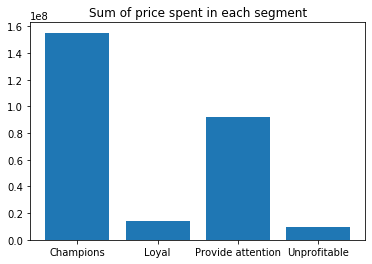

,rfm_label,price
0,Champions,1.553313e+08
1,Loyal,1.435158e+07
2,Provide attention,9.174944e+07
3,Unprofitable,9.417958e+06


In [97]:
price_sum = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].sum()).reset_index()
plt.bar(price_sum['rfm_label'],price_sum['price'])
plt.title('Sum of price spent in each segment')
plt.show()

price_sum

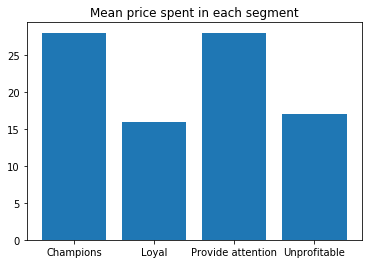

,rfm_label,price
0,Champions,28.068017
1,Loyal,15.980278
2,Provide attention,28.082555
3,Unprofitable,17.108410


In [98]:
price_mean = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].mean()).reset_index()
plt.bar(price_mean['rfm_label'],price_mean['price'])
plt.title('Mean price spent in each segment')
plt.show()

price_mean

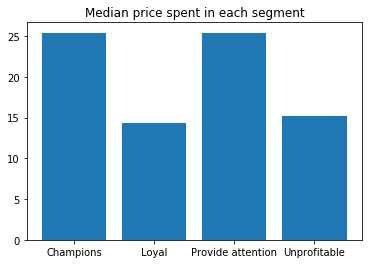

,rfm_label,price
0,Champions,25.406780
1,Loyal,14.389831
2,Provide attention,25.406780
3,Unprofitable,15.237288


In [99]:
price_median = pd.DataFrame(price_rfm.groupby('rfm_label')['price'].median()).reset_index()
plt.bar(price_median['rfm_label'],price_median['price'])
plt.title('Median price spent in each segment')
plt.show()

price_median